# HFA Mixed Effects Models
Created: 08/08/24 \
Updated: 08/14/2024 

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir   = f'{base_dir}ephys_analysis/results/regression_data/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

08142024


In [4]:
import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



subj_id  bdi
0    MS002   14
1    MS003    8
2    MS009   16
3    MS011   13
4    MS015   26
5    MS016   10
6    MS017   26
7    MS019   12
8    MS022   10
9    MS024   16
10   MS025   10
11   MS026    9
12   MS027   22
13   MS028   13
14   MS029   32
15   MS030   19
16   MS033   39
17   MS035   15
18   MS041   10
19   MS043   23
20   MS048   19
21   MS050    9
22     DA8   13
23   DA023   14
24   DA026   19
25   DA037    4
26   DA039   22

In [7]:
#### set theme for all plots
# %matplotlib inline
# from matplotlib import rc
# rc('text', usetex=False)

# sns.set_theme(style='ticks') 
# sns.set_context("talk")



In [8]:
# from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# import matplotlib as mpl
# from matplotlib import cm


# # saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# # 671351
# saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
# saez_hex_cmap  = ListedColormap(saez_colors)
# saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
# saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
# #plot_palette = saez_linear_cmap.resampled(lutsize=30)
# expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


# Load Regression DF

In [9]:
band = 'hfa'

In [10]:
band_df = pd.read_csv(f'{save_dir}{band}_master_df.csv')
band_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [11]:
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [12]:
roi_reref_labels_master_df.roi.value_counts()

dmpfc            216
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
stg              105
vlpfc             82
ains              71
smg               66
pins              60
thalamus          58
mtg               57
temporal pole     31
mcc               28
motor             25
phg               25
parietal          24
vmpfc             23
fusiform          19
occipital         19
itg               15
angular           14
somat             11
premotor           9
caudate            8
pcc                1
Name: roi, dtype: int64

In [13]:
#### filter df by rois with electrode counts >= 50 *** updated to >15
keep_rois = roi_reref_labels_master_df.roi.value_counts().index[roi_reref_labels_master_df.roi.value_counts(
).values>=20].tolist()

# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
#     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()
# keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg']     
keep_rois


['dmpfc',
 'ofc',
 'acc',
 'sts',
 'hpc',
 'amy',
 'dlpfc',
 'stg',
 'vlpfc',
 'ains',
 'smg',
 'pins',
 'thalamus',
 'mtg',
 'temporal pole',
 'mcc',
 'motor',
 'phg',
 'parietal',
 'vmpfc']

In [14]:
####### NEW DATA FRAME 
reg_df = band_df.copy()
reg_df = reg_df[reg_df.roi.isin(keep_rois)]
len(reg_df)

244136

In [15]:
np.max(reg_df.band_pow)

4.111088307352885

In [16]:
np.min(reg_df.band_pow)

-0.948025564176362

# POW ~ Outcome Vars Regressions

In [ ]:
# ###### BIC Testing - 
# final_vars   = ['decisionCPE'] # BIC -249856.56792628395
# final_vars   = ['RPE','decisionCPE'] # -249848.6044250971
# final_vars   = ['TrialEV','RPE','decisionCPE'] # -249828.8870830534
# final_vars   = ['C(GambleChoice)', 'TotalProfit', 'decisionCPE'] # -257798.71952021663
# final_vars   = ['C(TrialType)','TrialEV', 'TotalProfit', 'decisionCPE'] # -257467.88502797886
# final_vars   = ['C(GambleChoice)', 'TrialEV','TotalProfit', 'decisionCPE'] # -257748.64046136508
# final_vars   = ['C(GambleChoice)', 'TrialEV', 'decisionCPE'] # -250250.11090162286
# final_vars   = ['TrialEV', 'TotalProfit', 'decisionCPE'] # -257221.93331664318
# final_vars   = ['C(GambleChoice)', 'decisionCPE'] # -250288.05753364015
# final_vars   = ['TotalProfit', 'decisionCPE'] # -257227.6930595564
# final_vars   = ['TrialEV', 'decisionCPE'] # -249848.25629109397
# final_vars   = ['C(TrialType)','decisionCPE'] # -249890.84101338993
# final_vars   = ['C(TrialType)','TotalProfit', 'decisionCPE'] # -257407.7333453585
# final_vars   = ['C(TrialType)','TrialEV',  'decisionCPE'] # -249897.80612570498


In [15]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

In [16]:
final_vars   = ['C(GambleChoice)', 'TrialEV','TotalProfit', 'decisionCPE']
final_fit = fit_mixed_model(reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic    

                        Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          band_pow   
No. Observations:           244112           Method:                      ML         
No. Groups:                 1776             Scale:                       0.0195     
Min. group size:            65               Log-Likelihood:              129004.5767
Max. group size:            148              Converged:                   Yes        
Mean group size:            137.5                                                    
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                 -0.018    0.002 -11.395 0.000 -0.021 -0.015
C(GambleChoice)[T.safe]                    0.004    0.001   4.338 0.000  0.002

-257748.64046136508


# ROI REGRESSIONS
- test all ROIs & see which ROIs are significant
- correlate bdi with ROI beta coefficients 


In [17]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
final_vars   = ['C(GambleChoice)','TrialEV','TotalProfit','decisionCPE']

In [18]:
roi_fit_dict = {f'{roi}':fit_mixed_model(reg_df[reg_df.roi==roi],
                                        final_vars,outcome_var,rand_eff_var,reml=False) 
                for roi in reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],reg_df[reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)


In [19]:
roi_fit_results['band'] = band
roi_fit_results.to_csv(f'{save_dir}{band}_roi_reg_results.csv')

In [20]:
raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results.decisionCPE[roi_fit_results.roi == roi].unique(),
                 popmean=0) for roi in roi_fit_results.roi.unique().tolist()}
raw_roi_stats

{'acc': TtestResult(statistic=30.28321401886107, pvalue=4.800405465794209e-75, df=192),
 'dmpfc': TtestResult(statistic=3.0692388893597156, pvalue=0.0024223324949591667, df=215),
 'amy': TtestResult(statistic=27.543247336821004, pvalue=1.0745228597119667e-51, df=112),
 'sts': TtestResult(statistic=-4.013321778184722, pvalue=9.320012645712445e-05, df=154),
 'ains': TtestResult(statistic=2.3865349765329813, pvalue=0.019714818049999125, df=70),
 'vlpfc': TtestResult(statistic=7.877883454616958, pvalue=1.3066192499074748e-11, df=81),
 'hpc': TtestResult(statistic=1.9565491957210899, pvalue=0.05248001904019918, df=134),
 'mtg': TtestResult(statistic=2.5656189047951545, pvalue=0.013003651516086727, df=56),
 'ofc': TtestResult(statistic=15.587296994015182, pvalue=1.9575990103731212e-36, df=201),
 'pins': TtestResult(statistic=0.48218035525464753, pvalue=0.6314618495875994, df=59),
 'dlpfc': TtestResult(statistic=0.5513491134662052, pvalue=0.5825547388444174, df=106),
 'motor': TtestResult(sta

In [21]:
roi_fit_results

unique_reref_ch subj_id       roi  bdi  raw_Intercept  \
0           DA023_lac1-lac2   DA023       acc   14       0.007214   
1           DA023_lac2-lac3   DA023       acc   14       0.009459   
2           DA023_lac3-lac4   DA023       acc   14       0.004643   
3       MS002_lacas1-lacas2   MS002       acc   14       0.008705   
4       MS002_lacas2-lacas3   MS002       acc   14       0.010106   
...                     ...     ...       ...  ...            ...   
1771  MS050_lcmang3-lcmang4   MS050  thalamus    9      -0.003291   
1772  MS050_lcmang4-lcmang5   MS050  thalamus    9      -0.004888   
1773  MS050_rcmsmg1-rcmsmg2   MS050  thalamus    9      -0.001920   
1774  MS050_rcmsmg2-rcmsmg3   MS050  thalamus    9      -0.000031   
1775  MS050_rcmsmg3-rcmsmg4   MS050  thalamus    9       0.000649   

      raw_GambleChoice  raw_TrialEV  raw_TotalProfit  raw_decisionCPE  \
0            -0.007989     0.001738        -0.027813         0.000204   
1            -0.003254     0.003346        -0.025586        -0.000491   
2             0.005244     0.002455        -0.017967        -0.002233   
3            -0.007038     0.002786        -0.006983         0.002307   
4            -0.010304     0.002916        -0.002370         0.003793   
...                ...          ...              ...              ...   
1771          0.000524    -0.002492        -0.002747         0.000696   
1772          0.000676    -0.003502        -0.014902         0.004599   
1773          0.000182     0.002428        -0.006674         0.001522   
1774          0.000139    -0.000807        -0.000054         0.000121   
1775          0.000076    -0.002291        -0.006623         0.002679   

      Intercept  GambleChoice   TrialEV  TotalProfit  decisionCPE band  
0      0.003946     -0.014318  0.002808    -0.044196     0.006267  hfa  
1      0.006192     -0.009582  0.004416    -0.041969     0.005572  hfa  
2      0.001375     -0.001085  0.003525    -0.034350     0.003830  hfa  
3      0.005438     -0.013367  0.003856    -0.023365     0.008370  hfa  
4      0.006839     -0.016632  0.003987    -0.018753     0.009856  hfa  
...         ...           ...       ...          ...          ...  ...  
1771  -0.003434     -0.005471  0.000040    -0.005058     0.004538  hfa  
1772  -0.005031     -0.005319 -0.000970    -0.017213     0.008442  hfa  
1773  -0.002062     -0.005814  0.004960    -0.008985     0.005365  hfa  
1774  -0.000173     -0.005856  0.001725    -0.002365     0.003964  hfa  
1775   0.000506     -0.005919  0.000240    -0.008934     0.006521  hfa  

[1776 rows x 15 columns]

In [22]:
fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
# fe_params_pvals = {f'{roi}':roi_fit_dict[roi].pvalues for roi in list(roi_fit_dict.keys())}


In [23]:
fe_results = []
for fe_res in fe_params_results:
    
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))


In [24]:
fe_results = pd.concat(fe_results).reset_index(drop=True)

In [25]:
fe_results['roi_cpe_pval'] = [np.round(roi_fit_dict[roi].pvalues['decisionCPE'],4) for roi in fe_results.roi.tolist()]

In [26]:
fe_results

Intercept  C(GambleChoice)[T.safe]   TrialEV  TotalProfit  decisionCPE  \
0   -0.003268                -0.006328  0.001070    -0.016383     0.006063   
1   -0.007781                 0.004094  0.003185    -0.016321     0.000934   
2   -0.022986                 0.001860 -0.004113     0.005055     0.005977   
3   -0.018185                 0.000733  0.003200    -0.017999    -0.003130   
4    0.002974                 0.001724  0.002923     0.001323     0.003803   
5   -0.006529                 0.008360 -0.000517    -0.011900     0.002990   
6   -0.066809                 0.008019  0.004353     0.000272     0.001566   
7   -0.031222                 0.014226 -0.000491    -0.026168     0.006130   
8   -0.018035                 0.013958  0.001655    -0.011424     0.010375   
9   -0.057453                -0.000628  0.002393     0.008764     0.000633   
10  -0.015540                 0.017671  0.004062    -0.011551     0.001066   
11  -0.003990                 0.010922  0.002159    -0.006146     0.007495   
12  -0.078238                -0.012701  0.007831    -0.000931     0.019440   
13   0.009746                -0.003386 -0.000804    -0.008590    -0.000190   
14  -0.009603                 0.010053 -0.004701    -0.022624     0.004894   
15  -0.019789                -0.004594  0.002869     0.009605    -0.001800   
16  -0.008961                -0.008426  0.002187    -0.008555     0.008229   
17  -0.025077                -0.002216  0.002929    -0.008370     0.007902   
18   0.015173                 0.014987 -0.009023    -0.015614    -0.005644   
19  -0.000142                -0.005995  0.002532    -0.002311     0.003843   

              roi  roi_cpe_pval  
0             acc        0.0000  
1           dmpfc        0.4990  
2             amy        0.0014  
3             sts        0.3842  
4            ains        0.1765  
5           vlpfc        0.2936  
6             hpc        0.4437  
7             mtg        0.2960  
8             ofc        0.0000  
9            pins        0.8404  
10          dlpfc        0.7197  
11          motor        0.1690  
12          vmpfc        0.0004  
13            phg        0.9553  
14            smg        0.1070  
15            stg        0.6377  
16            mcc        0.0248  
17  temporal pole        0.1153  
18       parietal        0.2302  
19       thalamus        0.0139

In [27]:
bonferr_alpha = 0.05/len(fe_results)
bonferr_alpha

0.0025

In [28]:
sig_rois = fe_results.roi[fe_results.roi_cpe_pval <= bonferr_alpha].tolist()
sig_rois

['acc', 'amy', 'ofc', 'vmpfc']

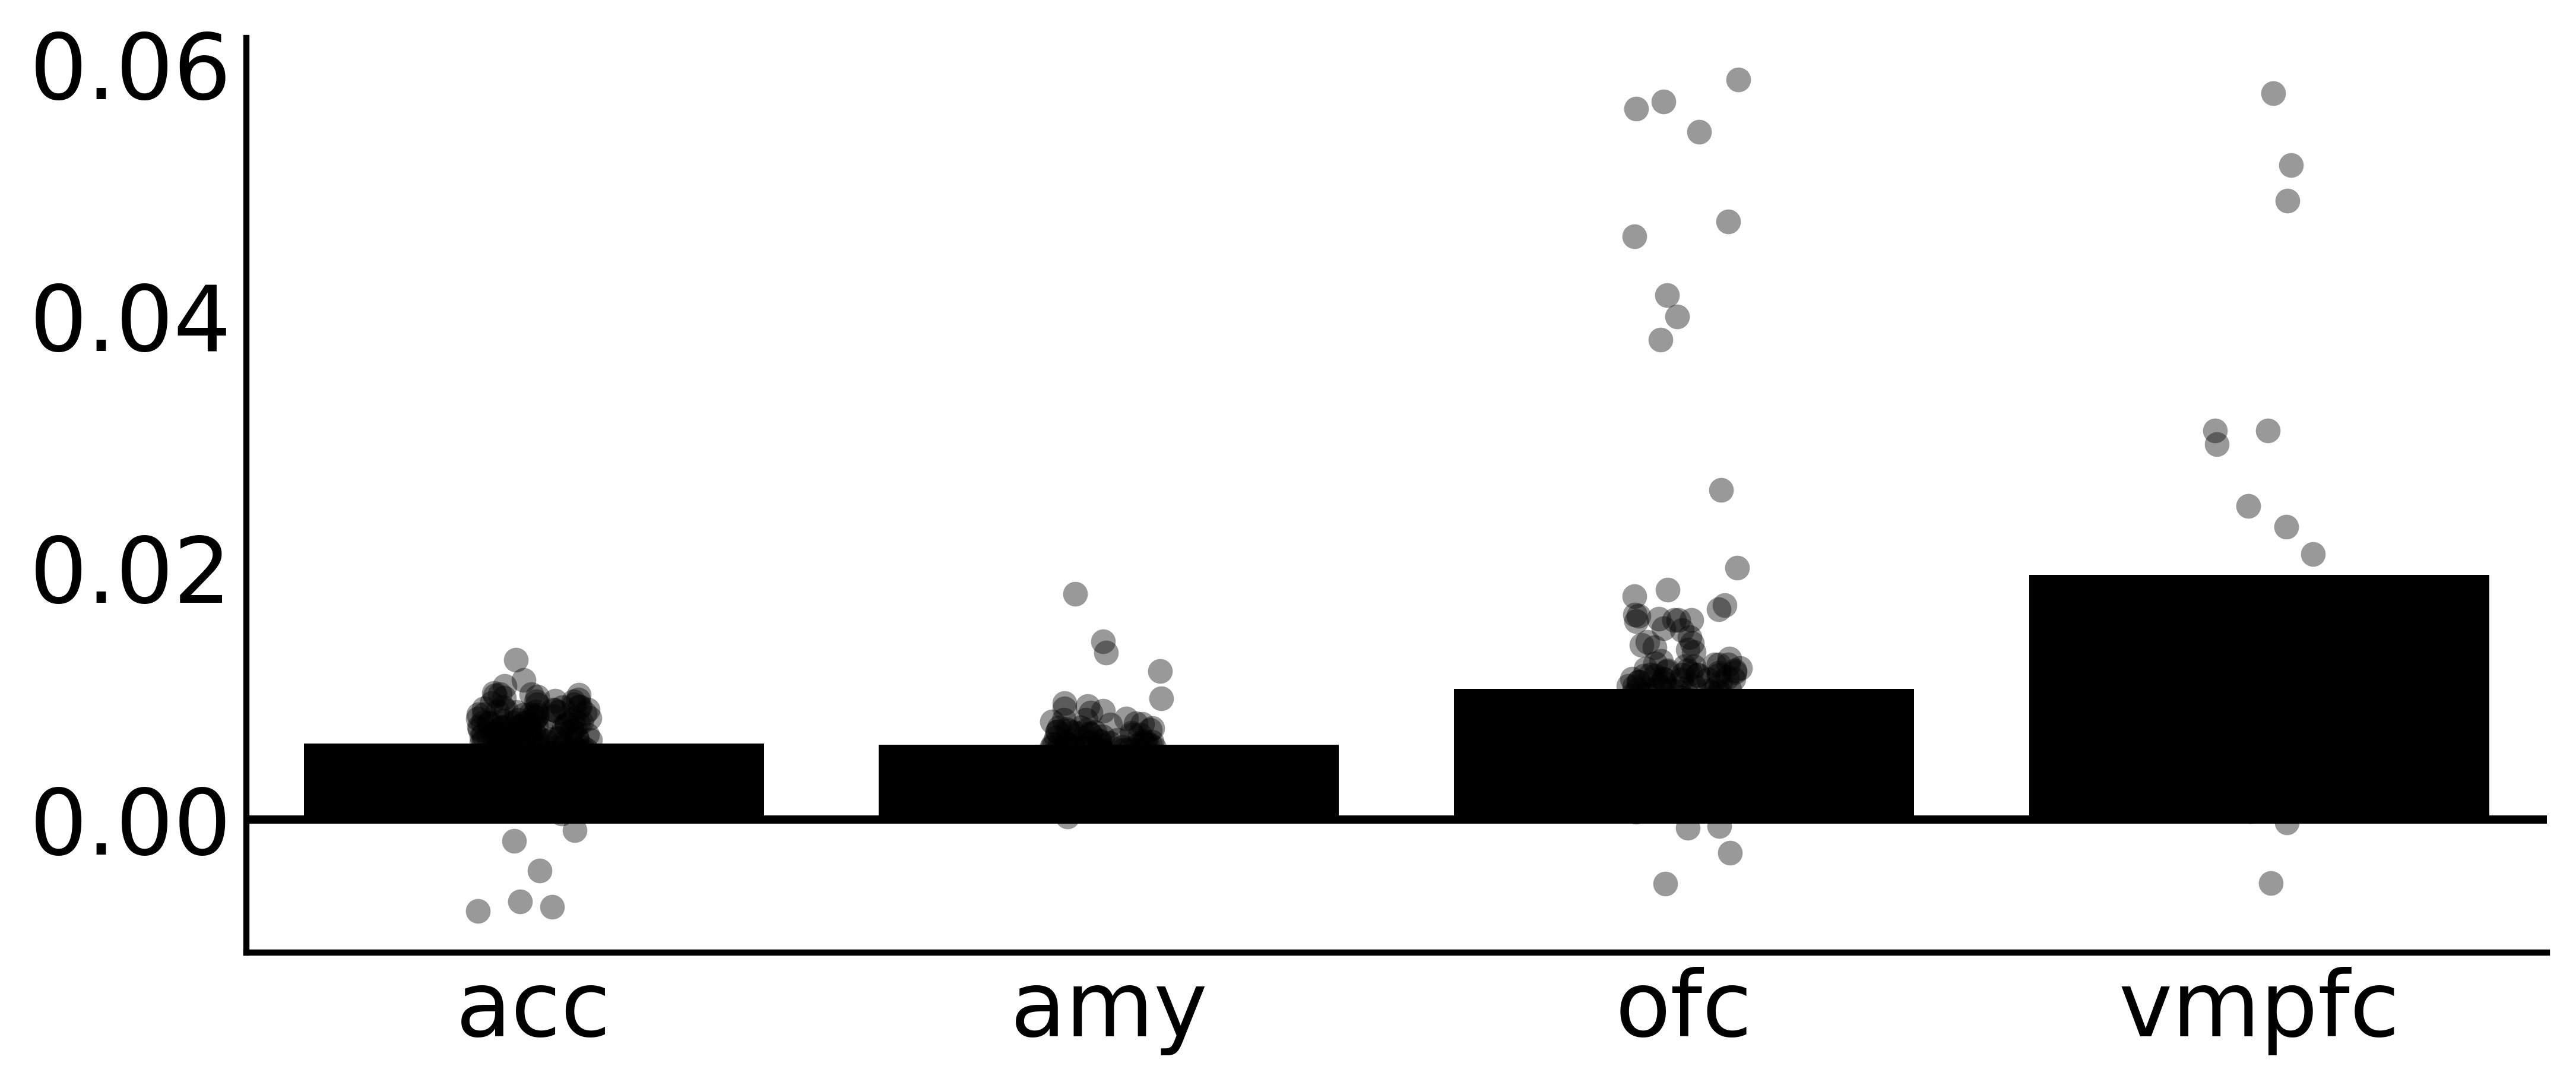

In [29]:
plot_roi_model_results(roi_fit_results,'roi','decisionCPE',bar_order=sig_rois)


#function info - 
# plot_roi_model_results(model_results,x_var,y_var,ylabel=None,color = 'k',bar_order=None,figsize=(10,4),dpi=500,linewidth=1.5,
#                            size=6,sns_context="poster",save_fig=False,save_dir=None,fig_id=None)


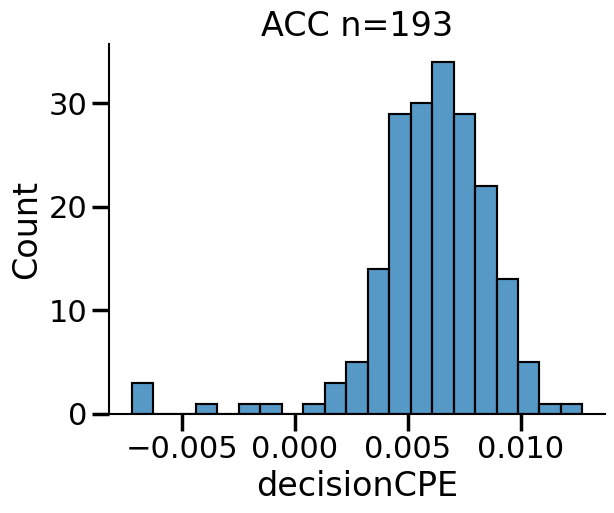

In [30]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
plt.title(f'ACC n={n}')

sns.despine()

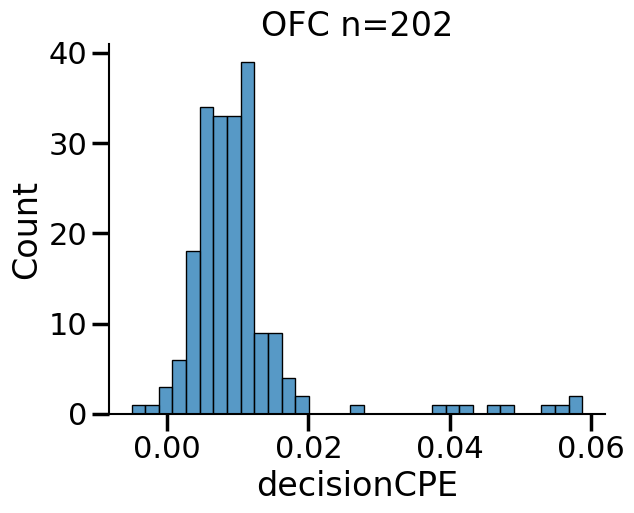

In [31]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'ofc'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'ofc'].decisionCPE)
plt.title(f'OFC n={n}')

sns.despine()

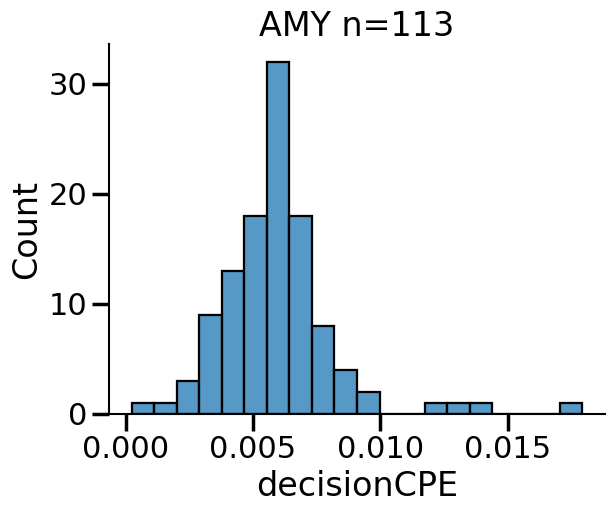

In [32]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'amy'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'amy'].decisionCPE)
plt.title(f'AMY n={n}')

sns.despine()

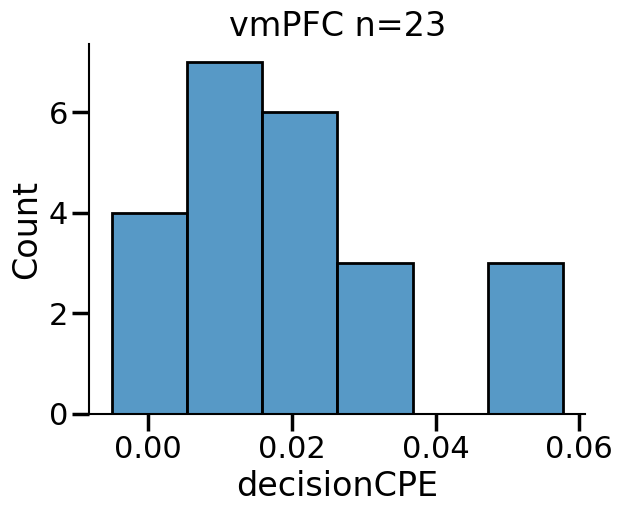

In [33]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'vmpfc'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'vmpfc'].decisionCPE)
plt.title(f'vmPFC n={n}')

sns.despine()

In [34]:
sig_rois

['acc', 'amy', 'ofc', 'vmpfc']

In [35]:
# CHECK BDI CORRELATION

rho_data = []
sig_rho = []

# BDI CORRELATIONS
for roi in roi_fit_results.roi.unique().tolist():
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.decisionCPE)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


acc pearsonr -0.04998231671393659 0.4900071565278387
dmpfc pearsonr -0.024579009647072693 0.7194496703076895
amy pearsonr -0.017159326505023654 0.8568453811852198
sts pearsonr -0.07904988372072148 0.3282090022217634
ains pearsonr -0.214866521621919 0.07194880213103441
vlpfc pearsonr -0.09205821749864174 0.4107504973979131
hpc pearsonr -0.20084067998844193 0.019506352111945163
mtg pearsonr -0.073304862949778 0.5878816723840494
ofc pearsonr -0.0432263479472337 0.541308933568894
pins pearsonr 0.29521034738016294 0.022028228685435285
dlpfc pearsonr -0.06998305159036164 0.4738144537331661
motor pearsonr -0.44641063478649984 0.025291064655087923
vmpfc pearsonr -0.0597594359292759 0.7865021016296183
phg pearsonr 0.14721551100530592 0.48253333735867804
smg pearsonr 0.35972047375965926 0.003011728198298363
stg pearsonr -0.16093771284725247 0.10098648220118157
mcc pearsonr -0.5430535478032655 0.0028250597327493495
temporal pole pearsonr -0.22218275774885285 0.22963041205499665
parietal pearsonr 

In [36]:
sig_rho

[('hpc', -0.20084067998844193, 0.019506352111945163),
 ('pins', 0.29521034738016294, 0.022028228685435285),
 ('motor', -0.44641063478649984, 0.025291064655087923),
 ('smg', 0.35972047375965926, 0.003011728198298363),
 ('mcc', -0.5430535478032655, 0.0028250597327493495)]

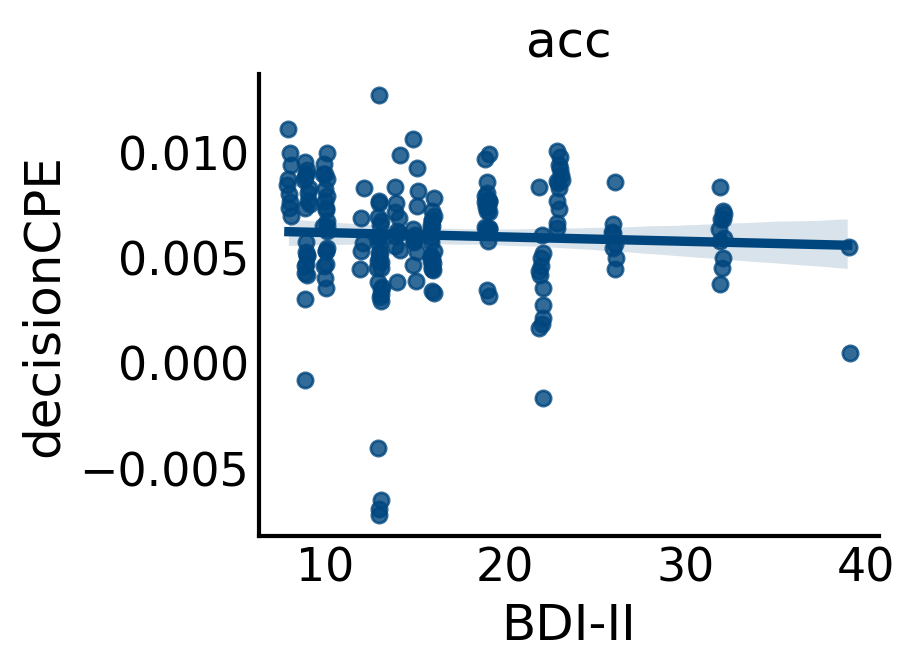

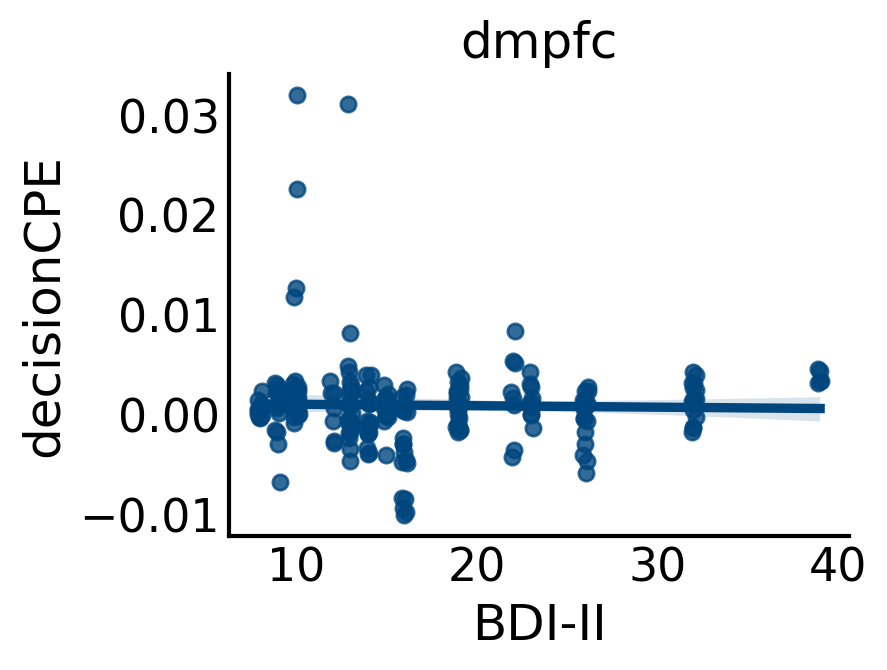

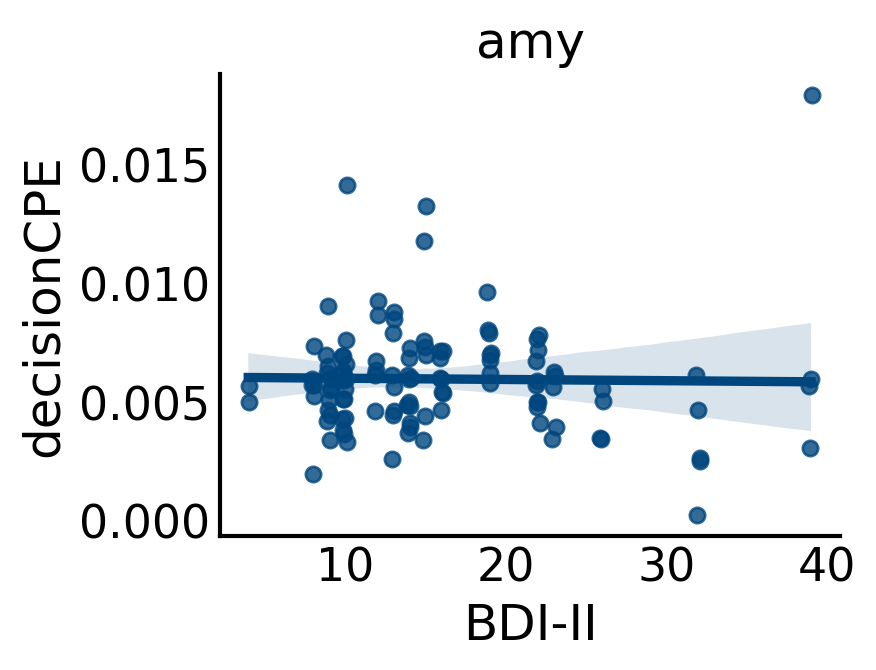

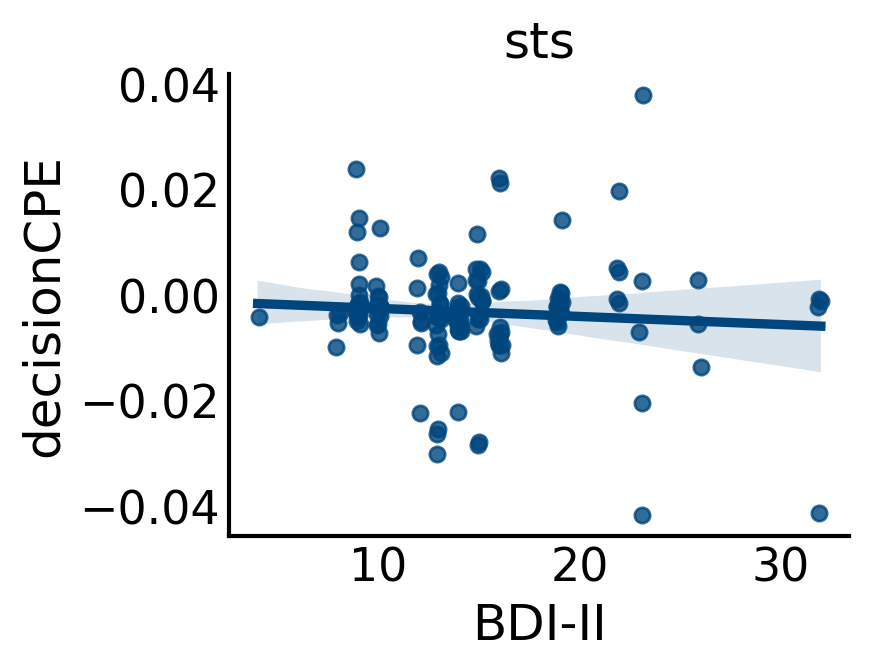

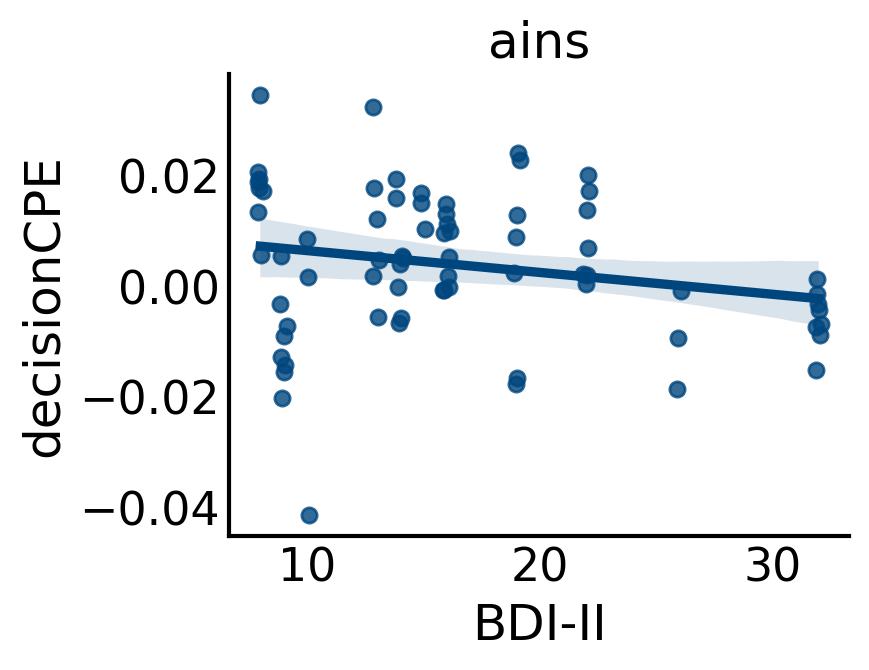

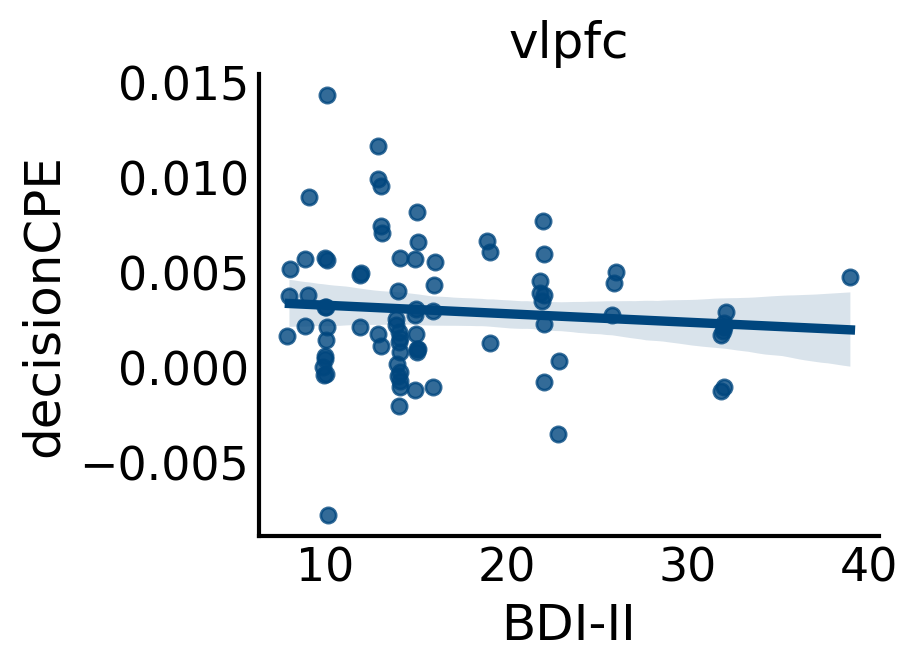

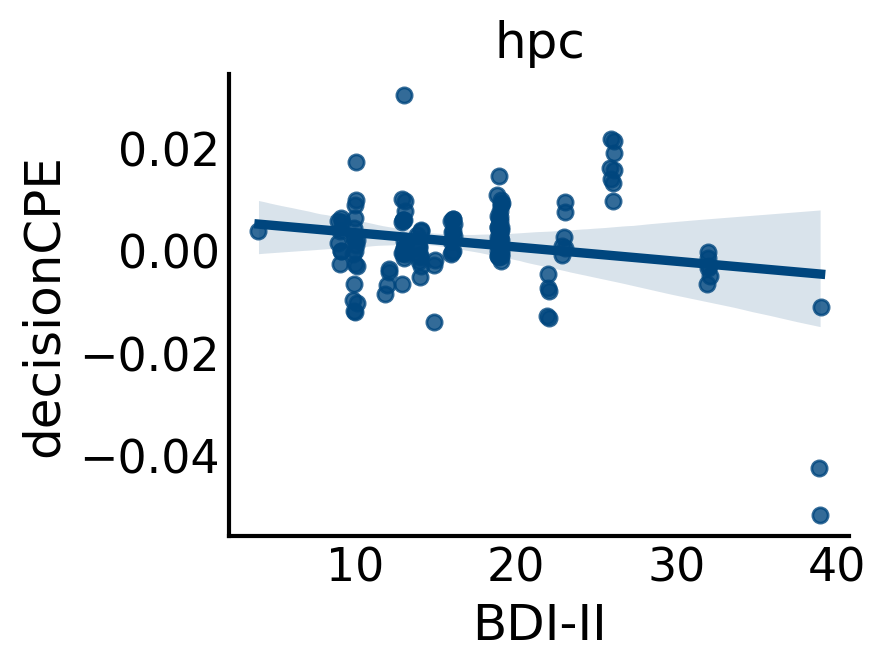

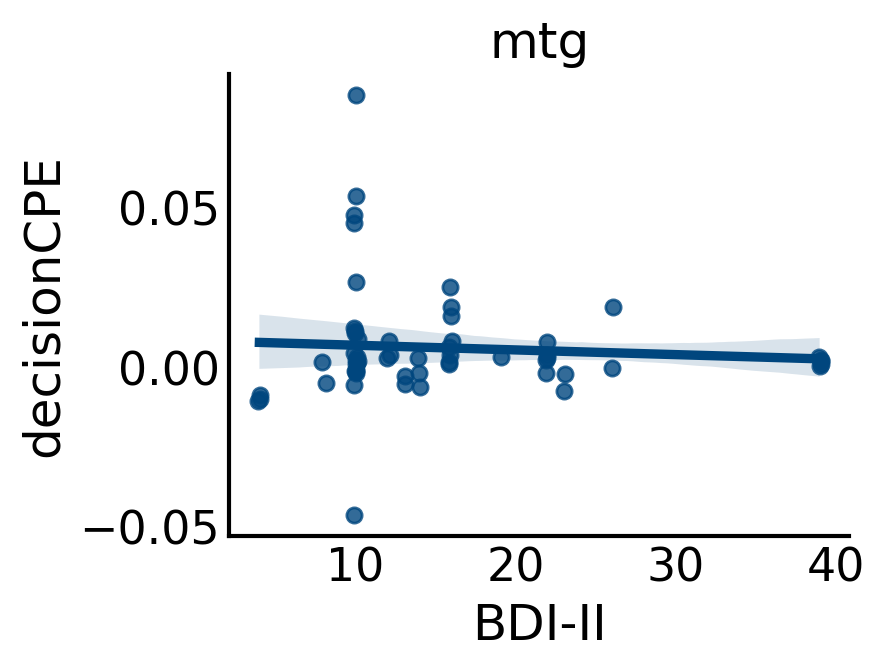

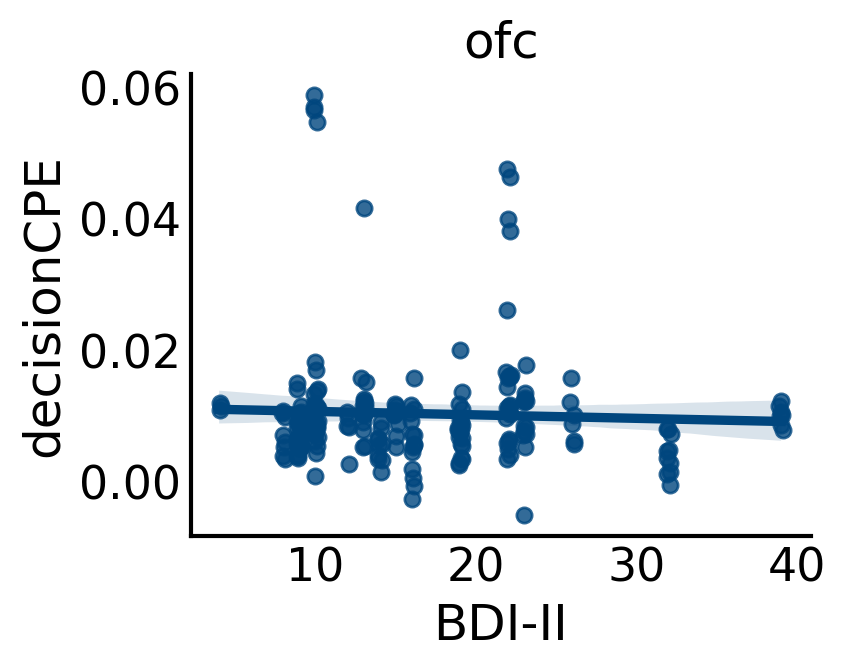

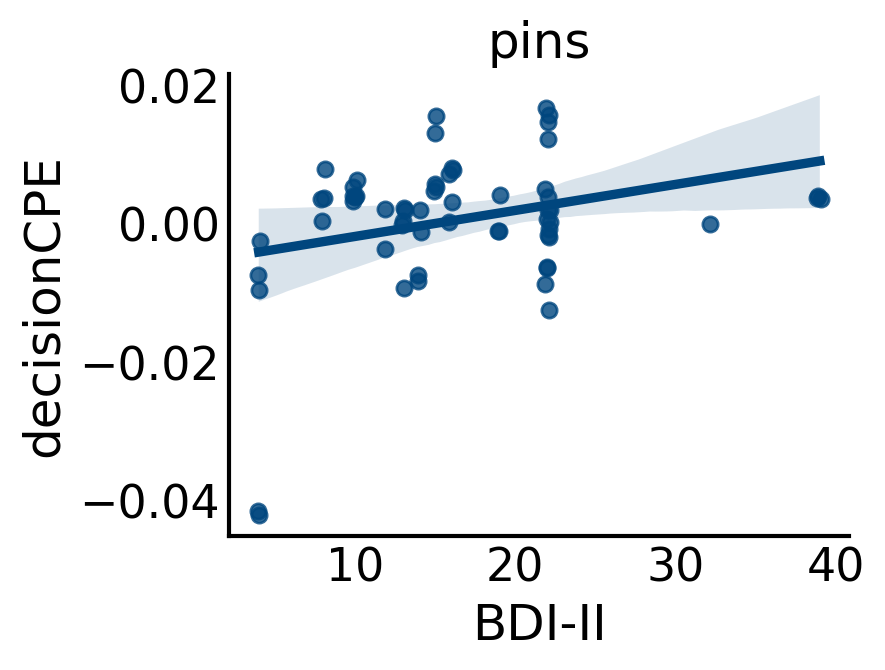

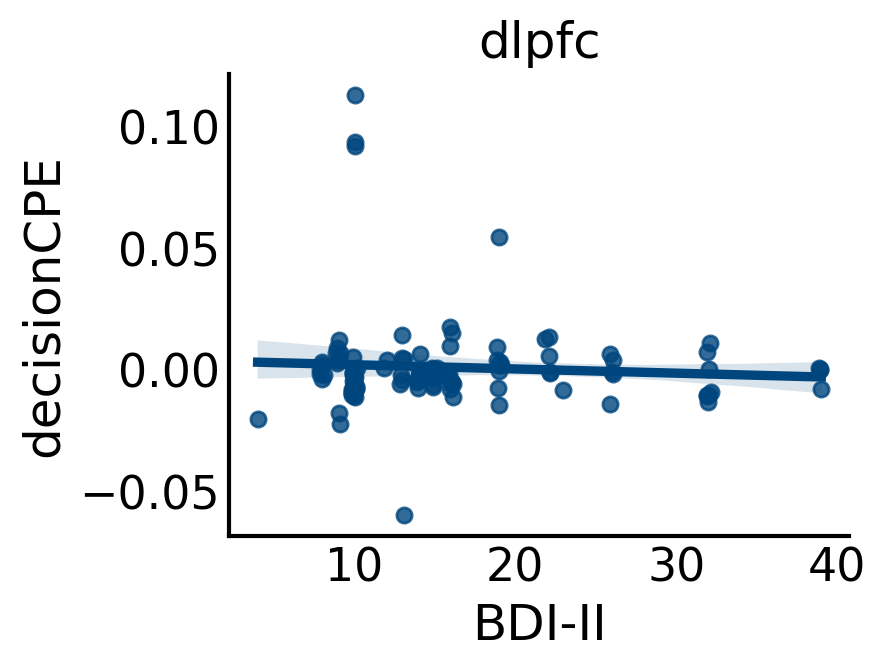

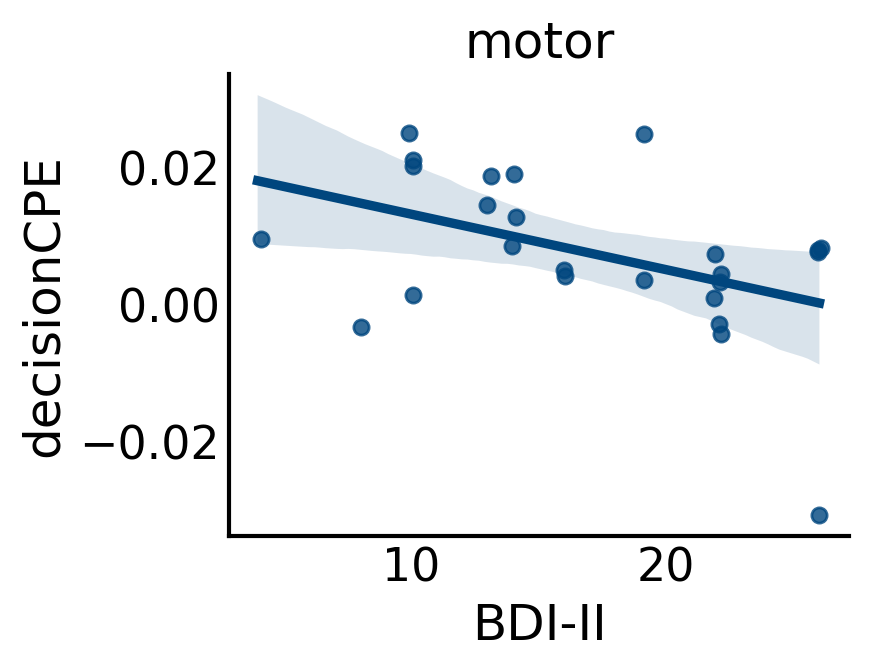

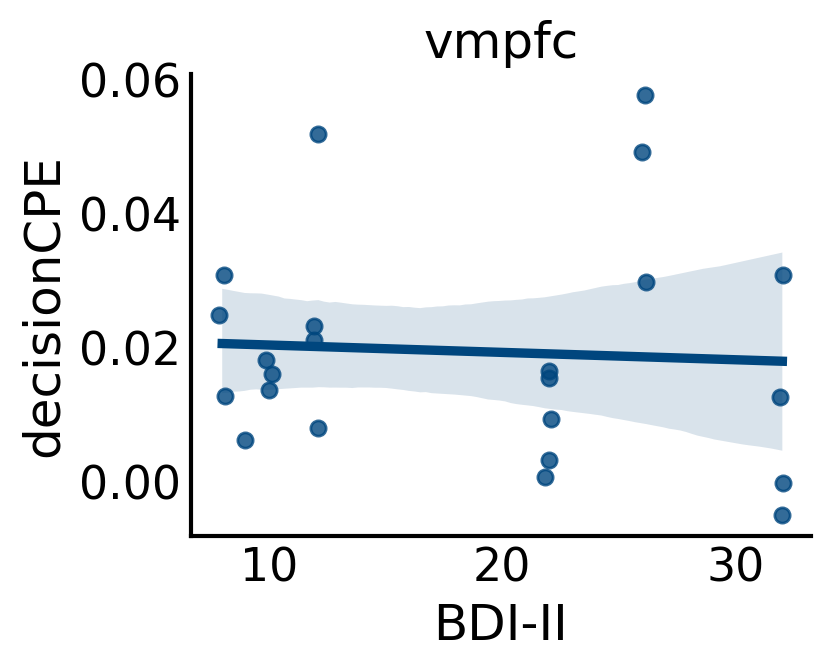

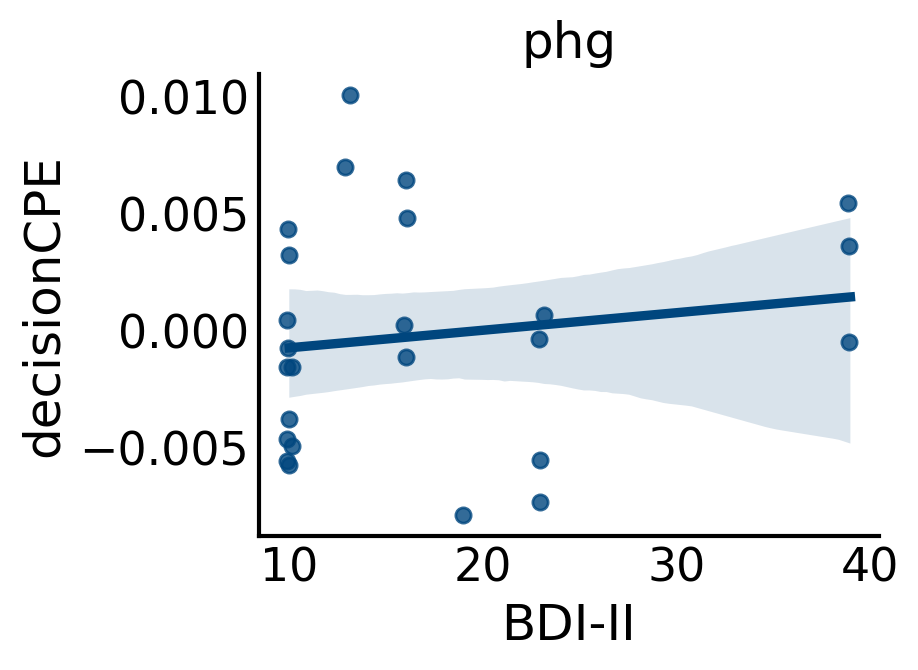

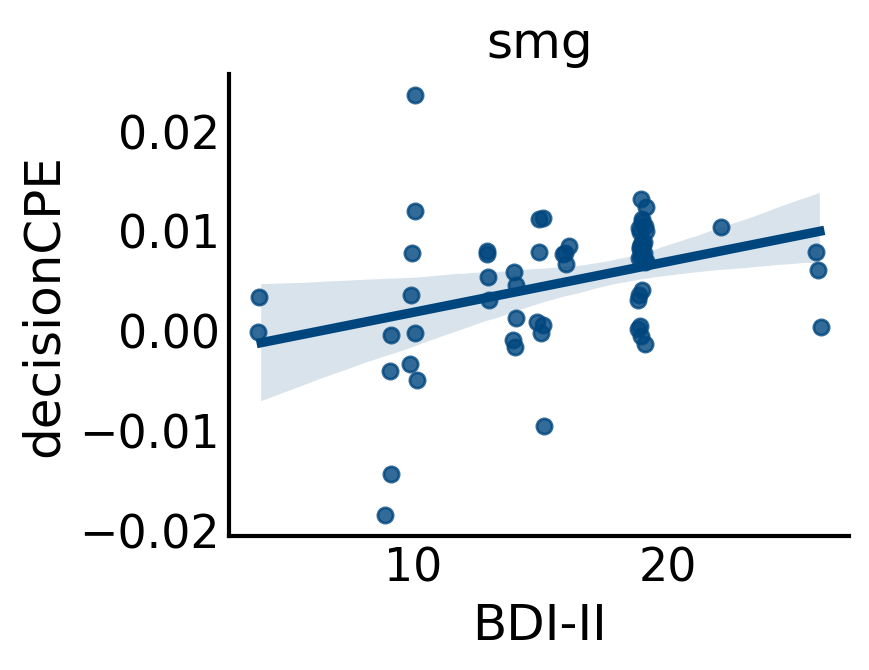

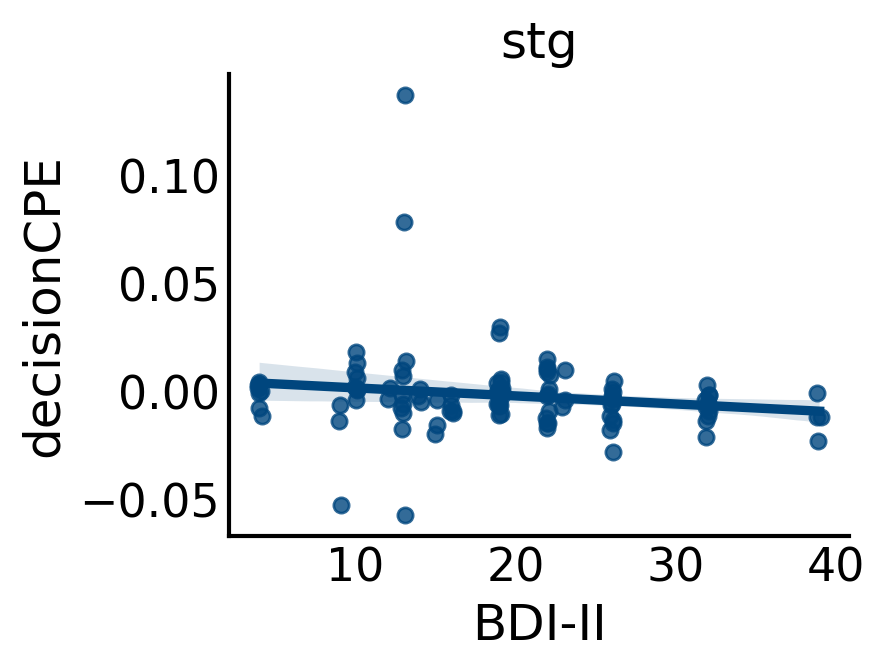

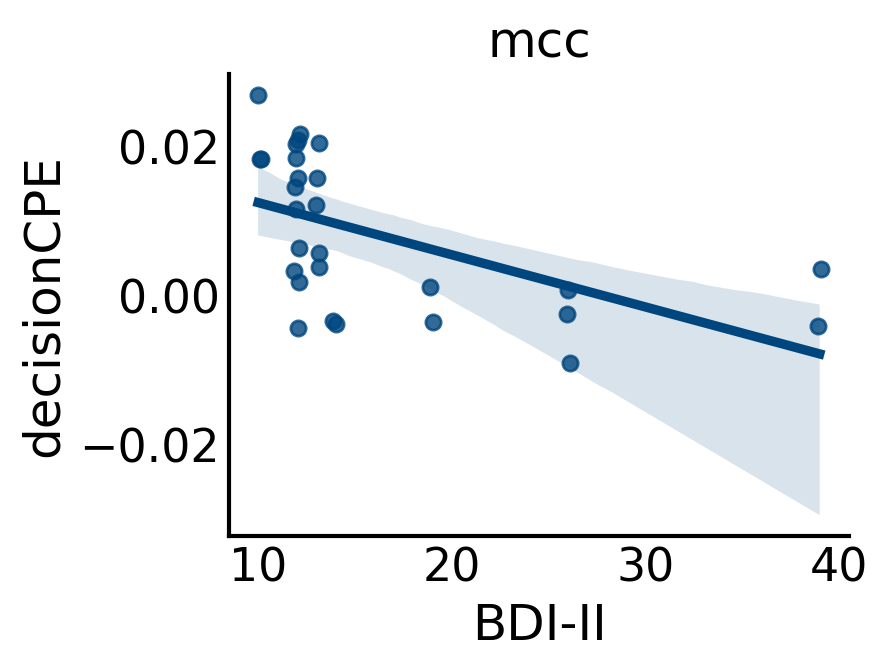

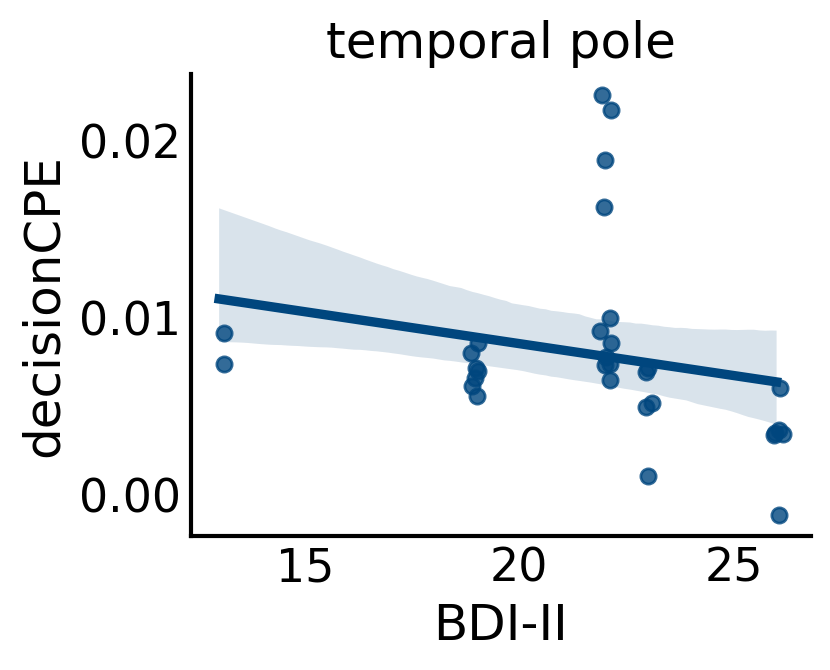

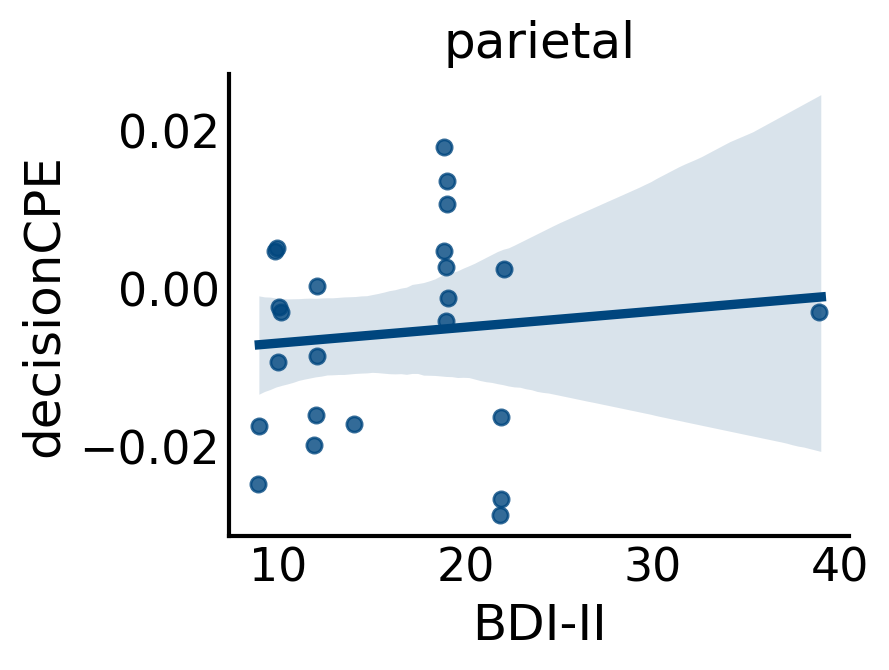

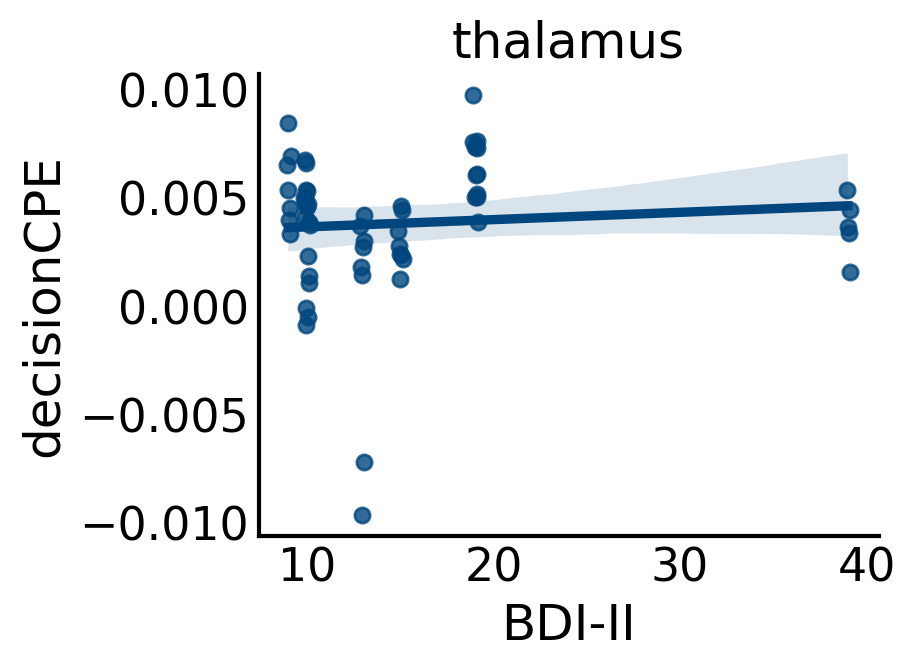

In [41]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in roi_fit_results.roi.unique().tolist():
    
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='decisionCPE',scatter=True,ci=95,
                fit_reg=True,color = '#00467e',x_jitter = 0.15,scatter_kws={'s':30}) #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
#     plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
#     plt.ylabel(fr'${band}_{{{zpow}}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}')
    sns.despine()
#     plt.tight_layout()


    
#     sns.despine()
    
# #     plt.savefig(f'{fig_save_dir}/{roi}_{rho}_{rho_p}_roi_bdi_beta-cpe-slope.pdf', format='pdf', metadata=None,
# #         bbox_inches='tight', pad_inches=0.1,dpi=300,
# #         facecolor='auto', edgecolor='auto',
# #         backend=None)
    

# RT ~ CPE:Pow Regressions

In [38]:
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

In [39]:
rt_vars   = ['decisionCPE','band_pow','decisionCPE:band_pow']
rt_fit = fit_mixed_model(reg_df,rt_vars,outcome_var,rand_eff_var,reml=False)
print(rt_fit.summary())
rt_fit.bic    

                      Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         logRT_t1    
No. Observations:         244112          Method:                     ML          
No. Groups:               1776            Scale:                      0.1323      
Min. group size:          65              Log-Likelihood:             -103683.1544
Max. group size:          148             Converged:                  No          
Mean group size:          137.5                                                   
----------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                               1.038    0.006 178.857 0.000  1.026  1.049
decisionCPE                             0.037    0.002  21.325 0.000  0.033  0.040
band_pow                   

207552.3894573438

In [60]:
rt_vars   = ['C(GambleChoice)','TrialEV','TotalProfit','decisionCPE','band_pow','decisionCPE:band_pow']
rt_fit = fit_mixed_model(reg_df,rt_vars,outcome_var,rand_eff_var,reml=False)
print(rt_fit.summary())
rt_fit.bic    

                            Mixed Linear Model Regression Results
Model:                        MixedLM             Dependent Variable:             logRT_t1    
No. Observations:             244112              Method:                         ML          
No. Groups:                   1776                Scale:                          0.1293      
Min. group size:              65                  Log-Likelihood:                 -102460.5632
Max. group size:              148                 Converged:                      No          
Mean group size:              137.5                                                           
----------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                           1.027    0.006 166.058 0.00

205367.72010441576


# ROI REGRESSIONS
- test all ROIs & see which ROIs are significant
- correlate bdi with ROI beta coefficients 


In [61]:
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'
rt_vars   = ['C(GambleChoice)','TrialEV','TotalProfit','decisionCPE','band_pow','decisionCPE:band_pow']


In [62]:
roi_fit_dict = {f'{roi}':fit_mixed_model(reg_df[reg_df.roi==roi],
                                        rt_vars,outcome_var,rand_eff_var,reml=False) 
                for roi in reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],reg_df[reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)


In [63]:
roi_fit_results['band'] = 'hfa'
roi_fit_results.to_csv(f'{save_dir}RT_hfa_roi_results.csv')

In [64]:
roi_fit_results

unique_reref_ch subj_id       roi  bdi  raw_Intercept  \
0           DA023_lac1-lac2   DA023       acc   14      -0.124959   
1           DA023_lac2-lac3   DA023       acc   14      -0.124723   
2           DA023_lac3-lac4   DA023       acc   14      -0.123995   
3       MS002_lacas1-lacas2   MS002       acc   14      -0.294543   
4       MS002_lacas2-lacas3   MS002       acc   14      -0.294009   
...                     ...     ...       ...  ...            ...   
1771  MS050_lcmang3-lcmang4   MS050  thalamus    9       0.253332   
1772  MS050_lcmang4-lcmang5   MS050  thalamus    9       0.252873   
1773  MS050_rcmsmg1-rcmsmg2   MS050  thalamus    9       0.253416   
1774  MS050_rcmsmg2-rcmsmg3   MS050  thalamus    9       0.254170   
1775  MS050_rcmsmg3-rcmsmg4   MS050  thalamus    9       0.254446   

      raw_GambleChoice  raw_TrialEV  raw_TotalProfit  raw_decisionCPE  \
0             0.010114     0.016836        -0.000422         0.011506   
1             0.009779     0.016615         0.000090         0.011226   
2             0.009765     0.016053        -0.000886         0.010827   
3             0.005067     0.026408         0.054064         0.012816   
4             0.004967     0.026259         0.053526         0.012352   
...                ...          ...              ...              ...   
1771          0.032015     0.026507        -0.131753         0.021220   
1772          0.032309     0.026634        -0.134914         0.021591   
1773          0.032129     0.026553        -0.132809         0.021374   
1774          0.031789     0.026507        -0.132178         0.021246   
1775          0.032611     0.026632        -0.134082         0.021815   

      raw_band_pow  raw_decisionCPE:band_pow  Intercept  GambleChoice  \
0        -0.086000                 -0.135514   0.885711      0.028952   
1        -0.023823                 -0.145669   0.885947      0.028617   
2        -0.099516                  0.050973   0.886675      0.028603   
3         0.143751                  0.089965   0.716127      0.023905   
4         0.170463                  0.046411   0.716661      0.023805   
...            ...                       ...        ...           ...   
1771     -0.031957                 -0.068700   1.244915      0.053496   
1772     -0.045376                  0.048753   1.244456      0.053790   
1773     -0.069126                 -0.104510   1.244999      0.053610   
1774      0.079518                 -0.138476   1.245753      0.053270   
1775     -0.102246                 -0.224245   1.246029      0.054092   

       TrialEV  TotalProfit  decisionCPE  band_pow  decisionCPE:band_pow band  
0     0.035305    -0.022754     0.044402 -0.047781             -0.172587  hfa  
1     0.035085    -0.022242     0.044121  0.014396             -0.182742  hfa  
2     0.034522    -0.023218     0.043723 -0.061298              0.013900  hfa  
3     0.044878     0.031732     0.045711  0.181970              0.052892  hfa  
4     0.044729     0.031194     0.045248  0.208682              0.009338  hfa  
...        ...          ...          ...       ...                   ...  ...  
1771  0.020374    -0.132832     0.073198 -0.148014             -0.006005  hfa  
1772  0.020501    -0.135993     0.073569 -0.161433              0.111448  hfa  
1773  0.020419    -0.133888     0.073352 -0.185183             -0.041815  hfa  
1774  0.020374    -0.133257     0.073225 -0.036539             -0.075781  hfa  
1775  0.020499    -0.135161     0.073793 -0.218303             -0.161550  hfa  

[1776 rows x 19 columns]

In [65]:
raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results['decisionCPE:band_pow'][roi_fit_results.roi == roi].unique(),
                 popmean=0) for roi in roi_fit_results.roi.unique().tolist()}
raw_roi_stats

{'acc': TtestResult(statistic=-5.22986294952798, pvalue=4.4128723269175256e-07, df=192),
 'dmpfc': TtestResult(statistic=-0.02650511606063025, pvalue=0.9788790379735073, df=215),
 'amy': TtestResult(statistic=-9.300077822179325, pvalue=1.363363513432564e-15, df=112),
 'sts': TtestResult(statistic=5.1463648349125135, pvalue=7.987219328460491e-07, df=154),
 'ains': TtestResult(statistic=1.9132837515666559, pvalue=0.05980218501254465, df=70),
 'vlpfc': TtestResult(statistic=-2.361005980521845, pvalue=0.02062837985383859, df=81),
 'hpc': TtestResult(statistic=-2.4712329637973536, pvalue=0.014719285814336838, df=134),
 'mtg': TtestResult(statistic=1.3035392177144505, pvalue=0.1977244425218225, df=56),
 'ofc': TtestResult(statistic=1.4791303409418843, pvalue=0.14067097164474757, df=201),
 'pins': TtestResult(statistic=3.5381341319806223, pvalue=0.0007926520589946631, df=59),
 'dlpfc': TtestResult(statistic=2.614889238751028, pvalue=0.010225752819931457, df=106),
 'motor': TtestResult(statist

In [66]:
roi_fit_results

unique_reref_ch subj_id       roi  bdi  raw_Intercept  \
0           DA023_lac1-lac2   DA023       acc   14      -0.124959   
1           DA023_lac2-lac3   DA023       acc   14      -0.124723   
2           DA023_lac3-lac4   DA023       acc   14      -0.123995   
3       MS002_lacas1-lacas2   MS002       acc   14      -0.294543   
4       MS002_lacas2-lacas3   MS002       acc   14      -0.294009   
...                     ...     ...       ...  ...            ...   
1771  MS050_lcmang3-lcmang4   MS050  thalamus    9       0.253332   
1772  MS050_lcmang4-lcmang5   MS050  thalamus    9       0.252873   
1773  MS050_rcmsmg1-rcmsmg2   MS050  thalamus    9       0.253416   
1774  MS050_rcmsmg2-rcmsmg3   MS050  thalamus    9       0.254170   
1775  MS050_rcmsmg3-rcmsmg4   MS050  thalamus    9       0.254446   

      raw_GambleChoice  raw_TrialEV  raw_TotalProfit  raw_decisionCPE  \
0             0.010114     0.016836        -0.000422         0.011506   
1             0.009779     0.016615         0.000090         0.011226   
2             0.009765     0.016053        -0.000886         0.010827   
3             0.005067     0.026408         0.054064         0.012816   
4             0.004967     0.026259         0.053526         0.012352   
...                ...          ...              ...              ...   
1771          0.032015     0.026507        -0.131753         0.021220   
1772          0.032309     0.026634        -0.134914         0.021591   
1773          0.032129     0.026553        -0.132809         0.021374   
1774          0.031789     0.026507        -0.132178         0.021246   
1775          0.032611     0.026632        -0.134082         0.021815   

      raw_band_pow  raw_decisionCPE:band_pow  Intercept  GambleChoice  \
0        -0.086000                 -0.135514   0.885711      0.028952   
1        -0.023823                 -0.145669   0.885947      0.028617   
2        -0.099516                  0.050973   0.886675      0.028603   
3         0.143751                  0.089965   0.716127      0.023905   
4         0.170463                  0.046411   0.716661      0.023805   
...            ...                       ...        ...           ...   
1771     -0.031957                 -0.068700   1.244915      0.053496   
1772     -0.045376                  0.048753   1.244456      0.053790   
1773     -0.069126                 -0.104510   1.244999      0.053610   
1774      0.079518                 -0.138476   1.245753      0.053270   
1775     -0.102246                 -0.224245   1.246029      0.054092   

       TrialEV  TotalProfit  decisionCPE  band_pow  decisionCPE:band_pow band  
0     0.035305    -0.022754     0.044402 -0.047781             -0.172587  hfa  
1     0.035085    -0.022242     0.044121  0.014396             -0.182742  hfa  
2     0.034522    -0.023218     0.043723 -0.061298              0.013900  hfa  
3     0.044878     0.031732     0.045711  0.181970              0.052892  hfa  
4     0.044729     0.031194     0.045248  0.208682              0.009338  hfa  
...        ...          ...          ...       ...                   ...  ...  
1771  0.020374    -0.132832     0.073198 -0.148014             -0.006005  hfa  
1772  0.020501    -0.135993     0.073569 -0.161433              0.111448  hfa  
1773  0.020419    -0.133888     0.073352 -0.185183             -0.041815  hfa  
1774  0.020374    -0.133257     0.073225 -0.036539             -0.075781  hfa  
1775  0.020499    -0.135161     0.073793 -0.218303             -0.161550  hfa  

[1776 rows x 19 columns]

In [67]:
fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
# fe_params_pvals = {f'{roi}':roi_fit_dict[roi].pvalues for roi in list(roi_fit_dict.keys())}


In [68]:
fe_results = []
for fe_res in fe_params_results:
    
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))


In [69]:
fe_results = pd.concat(fe_results).reset_index(drop=True)

In [75]:
fe_results['roi_cpepow_pval'] = [roi_fit_dict[roi].pvalues['decisionCPE:band_pow'] for roi in fe_results.roi.tolist()]


In [76]:
fe_results

Intercept  C(GambleChoice)[T.safe]   TrialEV  TotalProfit  decisionCPE  \
0    1.010670                 0.018838  0.018470    -0.022332     0.032896   
1    0.983258                 0.025103  0.024228    -0.001769     0.044912   
2    1.032660                 0.021457  0.026088    -0.011609     0.036990   
3    1.031507                 0.033788  0.033623    -0.031777     0.024870   
4    0.984169                 0.035751  0.029294    -0.005404     0.046376   
5    1.007250                 0.026740  0.039927     0.021168     0.031119   
6    0.990265                 0.009958  0.012643     0.008203     0.029936   
7    1.087960                 0.001014  0.014506    -0.000058     0.050144   
8    1.032979                 0.015672  0.019040    -0.004137     0.036903   
9    1.104257                -0.003553  0.023803    -0.002798     0.029987   
10   1.020281                 0.025502  0.012298     0.015932     0.039437   
11   1.163319                 0.010996  0.025351    -0.006216    -0.000656   
12   1.019003                 0.053293  0.020453    -0.008198     0.070310   
13   0.880975                 0.015284 -0.008696    -0.023840     0.053933   
14   1.128470                 0.009960  0.001702    -0.021181     0.010674   
15   1.029566                 0.010382  0.018806     0.020325     0.042114   
16   1.081187                 0.023420  0.010298     0.022793     0.029594   
17   1.129364                 0.046364  0.028012    -0.019797     0.012989   
18   1.207343                 0.020755  0.032071     0.000713     0.038497   
19   0.991583                 0.021481 -0.006133    -0.001079     0.051978   

    band_pow  decisionCPE:band_pow            roi  roi_cpe:pow_pval  \
0   0.038219             -0.037073            acc          0.546290   
1   0.069492             -0.000260          dmpfc          0.995667   
2  -0.010927             -0.100725            amy          0.231452   
3   0.015374              0.031887            sts          0.424823   
4  -0.019504              0.033647           ains          0.735423   
5   0.047411             -0.026692          vlpfc          0.686514   
6  -0.028309             -0.034235            hpc          0.531016   
7  -0.000327              0.012474            mtg          0.734501   
8   0.033288              0.011499            ofc          0.813302   
9  -0.001510              0.032096           pins               NaN   
10  0.002698              0.024961          dlpfc          0.726914   
11  0.095351              0.089413          motor          0.315664   
12 -0.018175              0.026674          vmpfc          0.888721   
13  0.027118              0.152915            phg          0.382524   
14  0.044754             -0.122465            smg          0.328999   
15  0.007736             -0.117187            stg          0.045233   
16  0.234748             -0.111582            mcc          0.375773   
17 -0.139683              0.046564  temporal pole               NaN   
18  0.036590             -0.273276       parietal          0.018051   
19 -0.116057              0.062695       thalamus          0.633724   

    roi_cpepow_pval  
0          0.546290  
1          0.995667  
2          0.231452  
3          0.424823  
4          0.735423  
5          0.686514  
6          0.531016  
7          0.734501  
8          0.813302  
9               NaN  
10         0.726914  
11         0.315664  
12         0.888721  
13         0.382524  
14         0.328999  
15         0.045233  
16         0.375773  
17              NaN  
18         0.018051  
19         0.633724

In [73]:
bonferr_alpha = 0.05/len(fe_results)
bonferr_alpha

0.0025

In [77]:
sig_rois = fe_results.roi[fe_results.roi_cpepow_pval <= bonferr_alpha].tolist()
sig_rois

[]

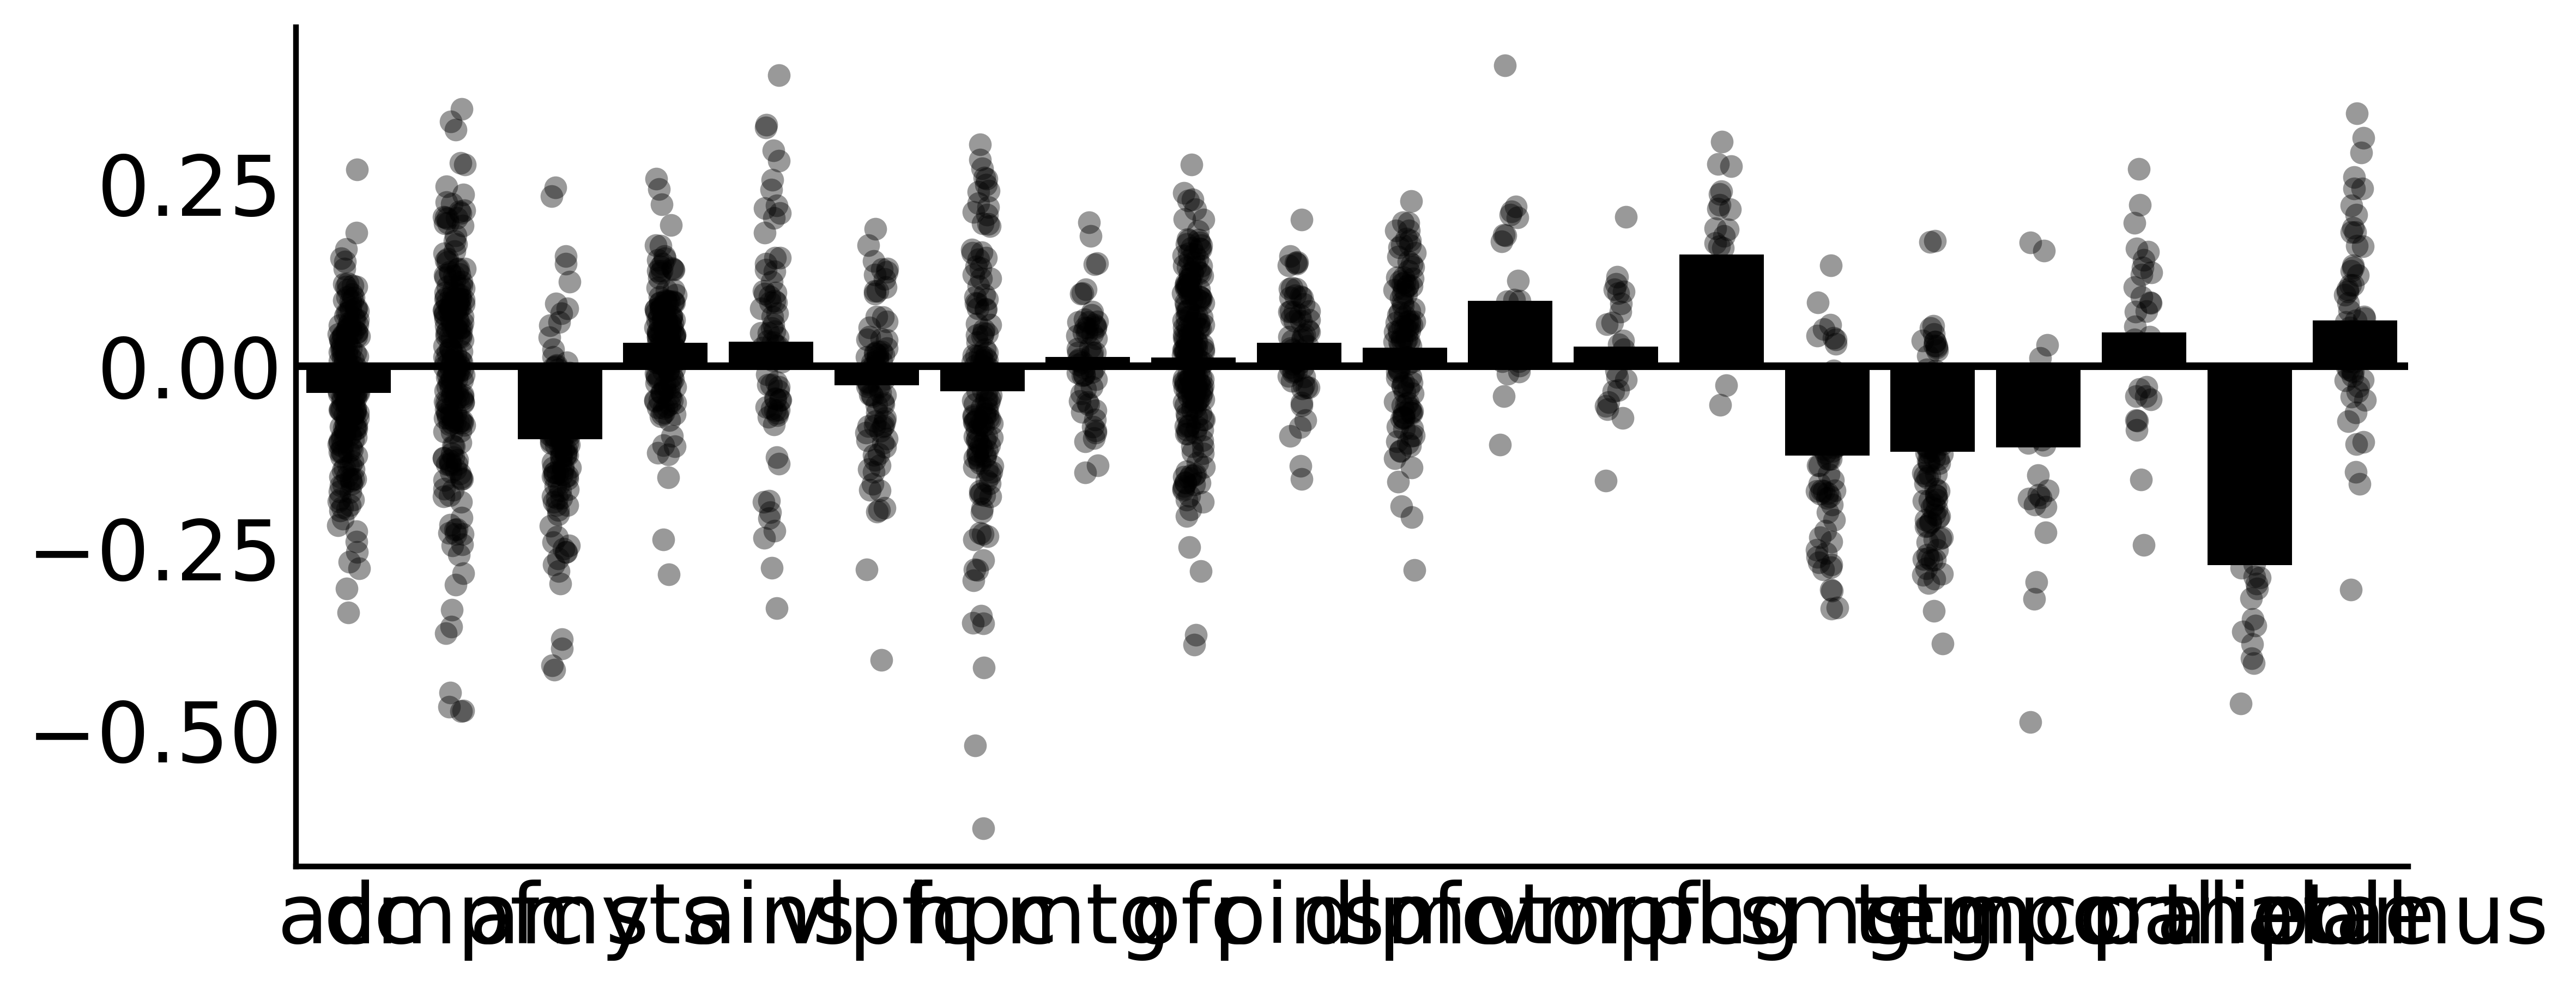

In [81]:
plot_roi_model_results(roi_fit_results,'roi','decisionCPE:band_pow')


#function info - 
# plot_roi_model_results(model_results,x_var,y_var,ylabel=None,color = 'k',bar_order=None,figsize=(10,4),dpi=500,linewidth=1.5,
#                            size=6,sns_context="poster",save_fig=False,save_dir=None,fig_id=None)


In [ ]:
# # plot ROI beta distribution
# sns.histplot(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
# n = len(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
# plt.title(f'ACC n={n}')

# sns.despine()

In [82]:
# CHECK BDI CORRELATION

rho_data = []
sig_rho = []

# BDI CORRELATIONS
for roi in roi_fit_results.roi.unique().tolist():
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data['decisionCPE:band_pow'])
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


acc pearsonr -0.1627217310559381 0.02375874511895636
dmpfc pearsonr -0.2857318474399516 2.0056959727292035e-05
amy pearsonr -0.2530302494912694 0.006851185049759069
sts pearsonr -0.14275567487774346 0.07639548011416014
ains pearsonr 0.2579776141696503 0.029849261090090104
vlpfc pearsonr -0.0991383782673751 0.37554214033502525
hpc pearsonr -0.31647414839341137 0.00018439414366427817
mtg pearsonr -0.16164940259501487 0.22963176341763064
ofc pearsonr -0.21878498918738745 0.001758753732813181
pins pearsonr -0.127034922571373 0.3334267271323773
dlpfc pearsonr -0.03684187406761234 0.7063615587719173
motor pearsonr -0.09070845479603973 0.666313158554203
vmpfc pearsonr -0.45845492275792404 0.02779473094150374
phg pearsonr -0.06581822022435056 0.7545982997101518
smg pearsonr -0.06943745540381131 0.5795763459794915
stg pearsonr -0.07241637607784882 0.46287011007317663
mcc pearsonr -0.4892806555381535 0.008231876704787217
temporal pole pearsonr 0.11643053717777209 0.5327948867792579
parietal pear

In [83]:
sig_rho

[('acc', -0.1627217310559381, 0.02375874511895636),
 ('dmpfc', -0.2857318474399516, 2.0056959727292035e-05),
 ('amy', -0.2530302494912694, 0.006851185049759069),
 ('ains', 0.2579776141696503, 0.029849261090090104),
 ('hpc', -0.31647414839341137, 0.00018439414366427817),
 ('ofc', -0.21878498918738745, 0.001758753732813181),
 ('vmpfc', -0.45845492275792404, 0.02779473094150374),
 ('mcc', -0.4892806555381535, 0.008231876704787217),
 ('parietal', 0.494374443756881, 0.014062397731748756),
 ('thalamus', 0.31015073415990224, 0.01781833932067658)]

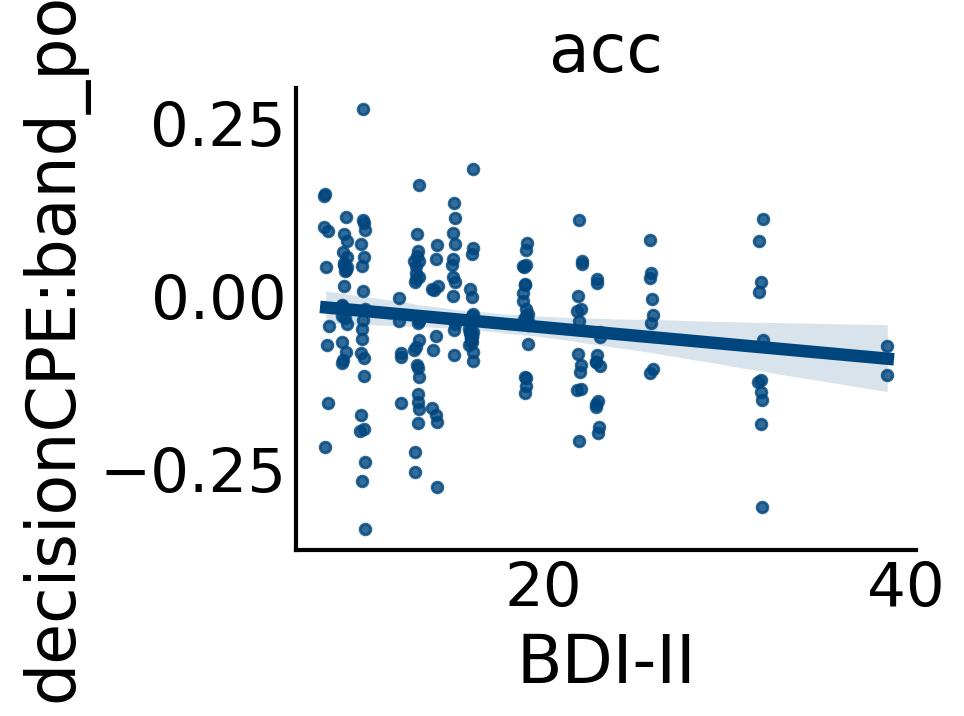

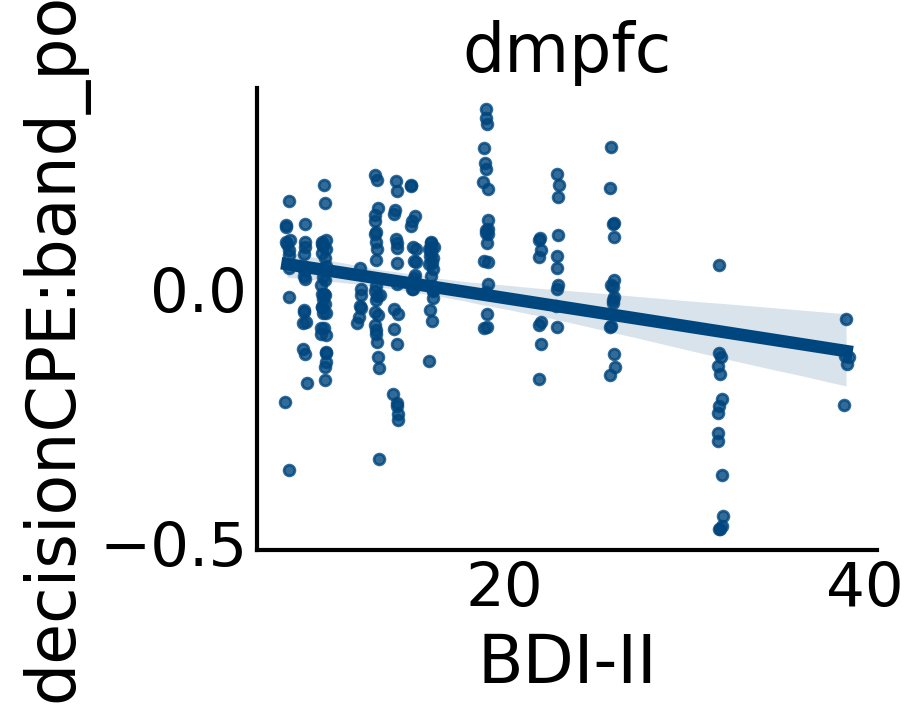

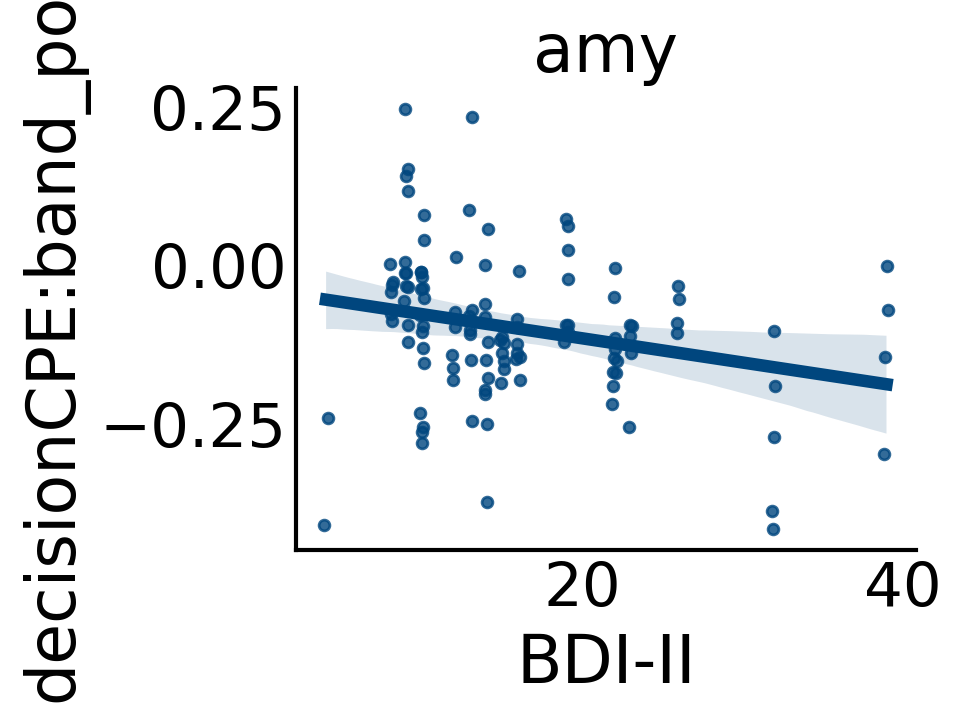

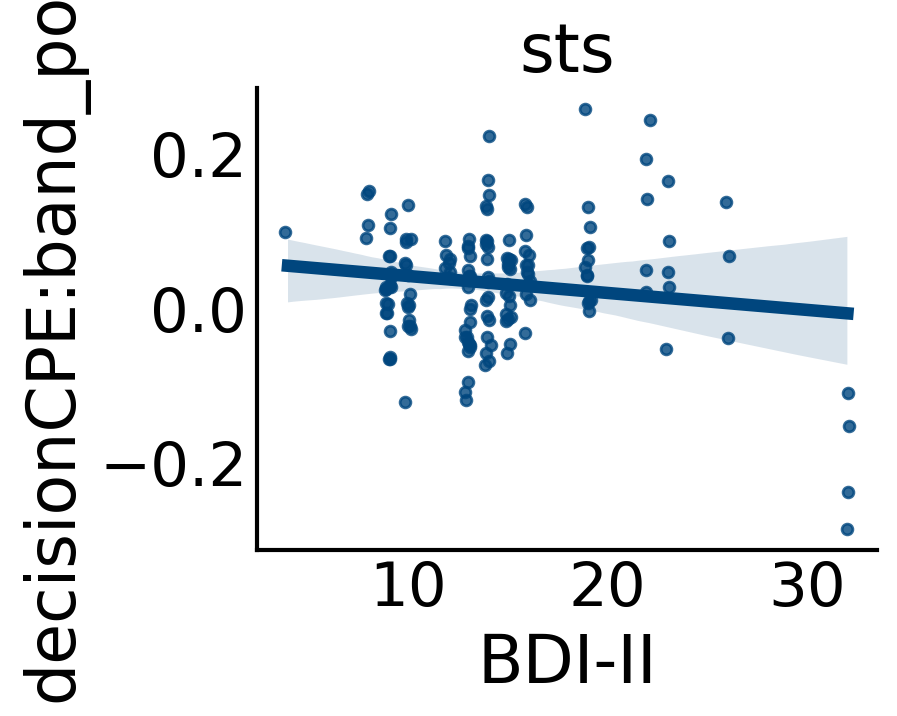

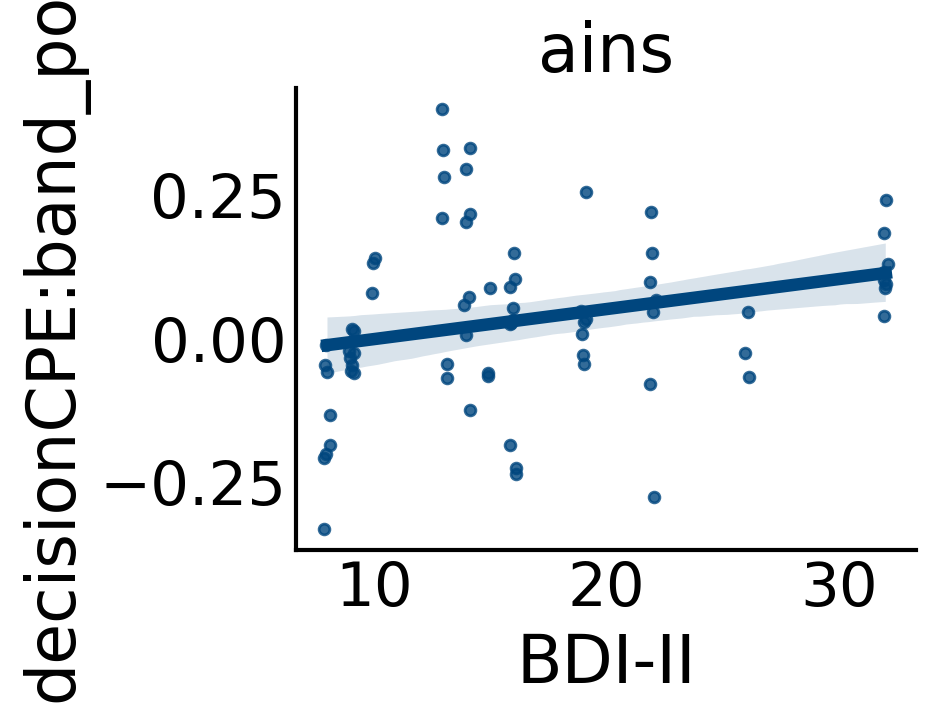

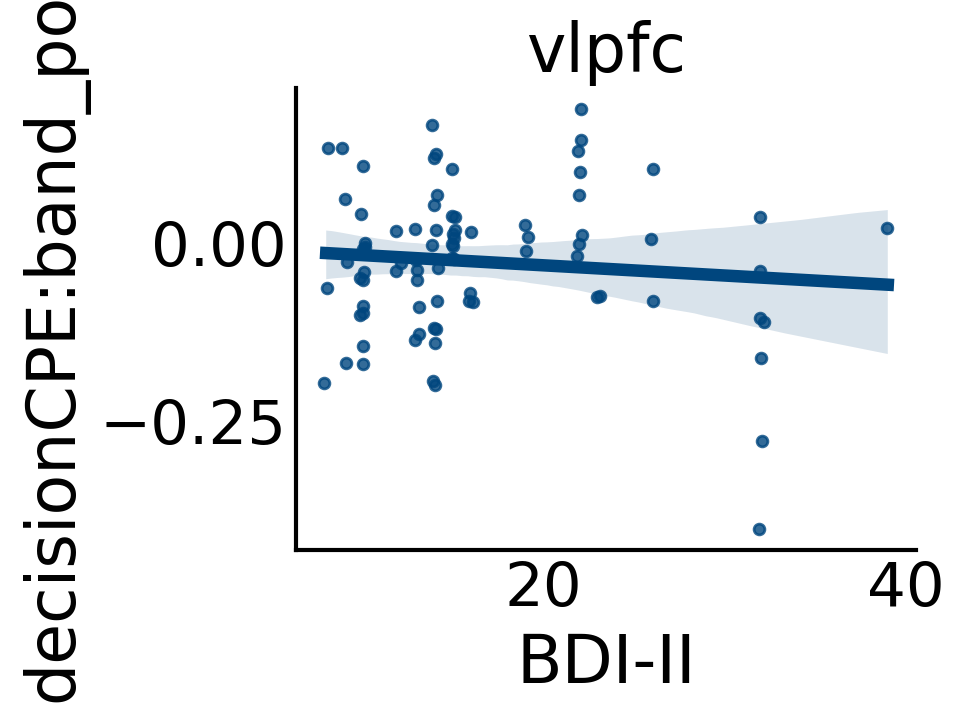

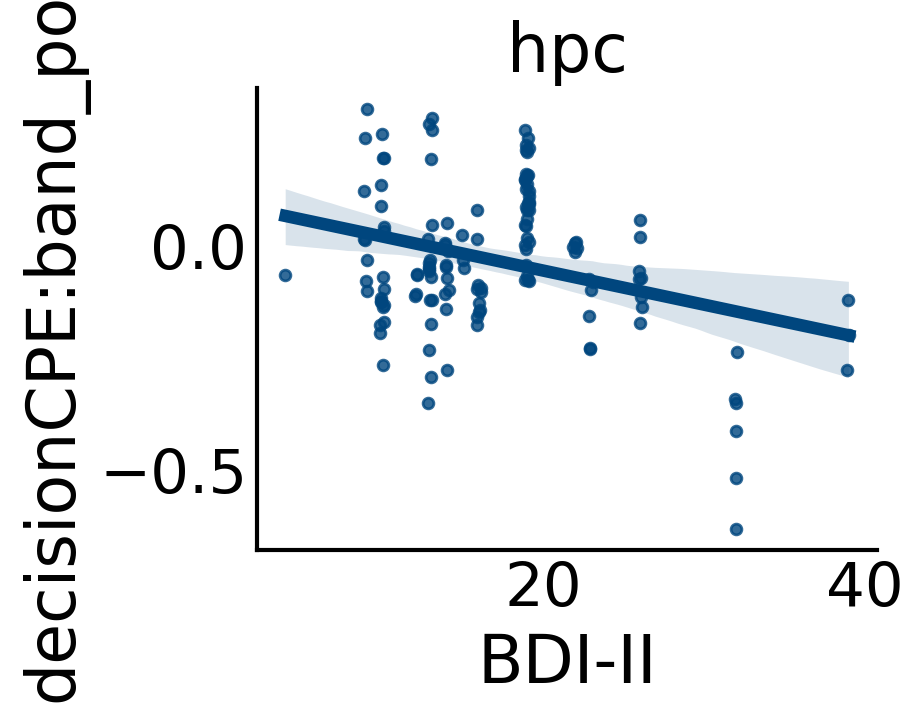

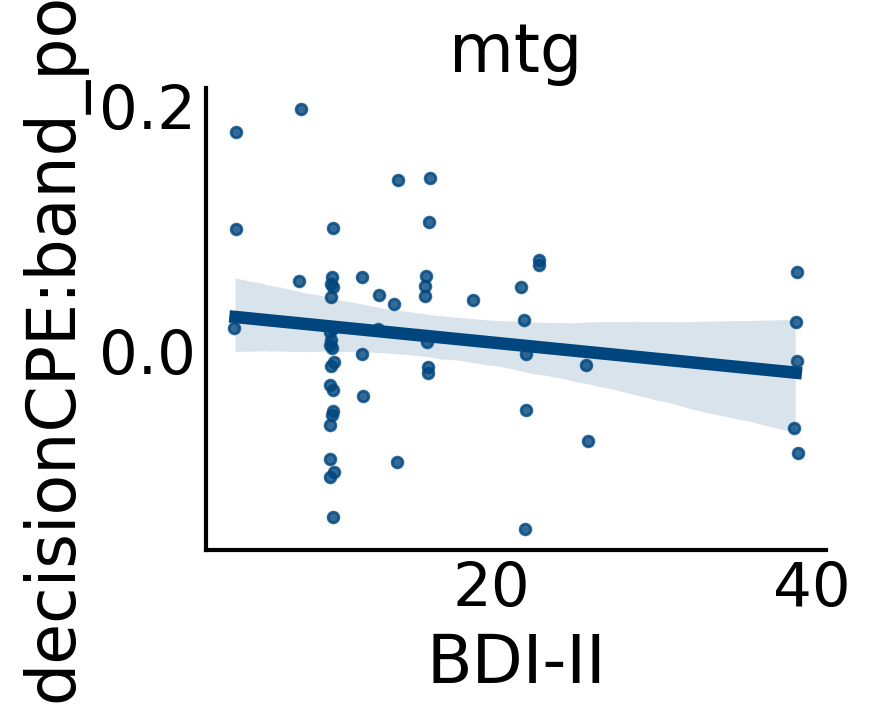

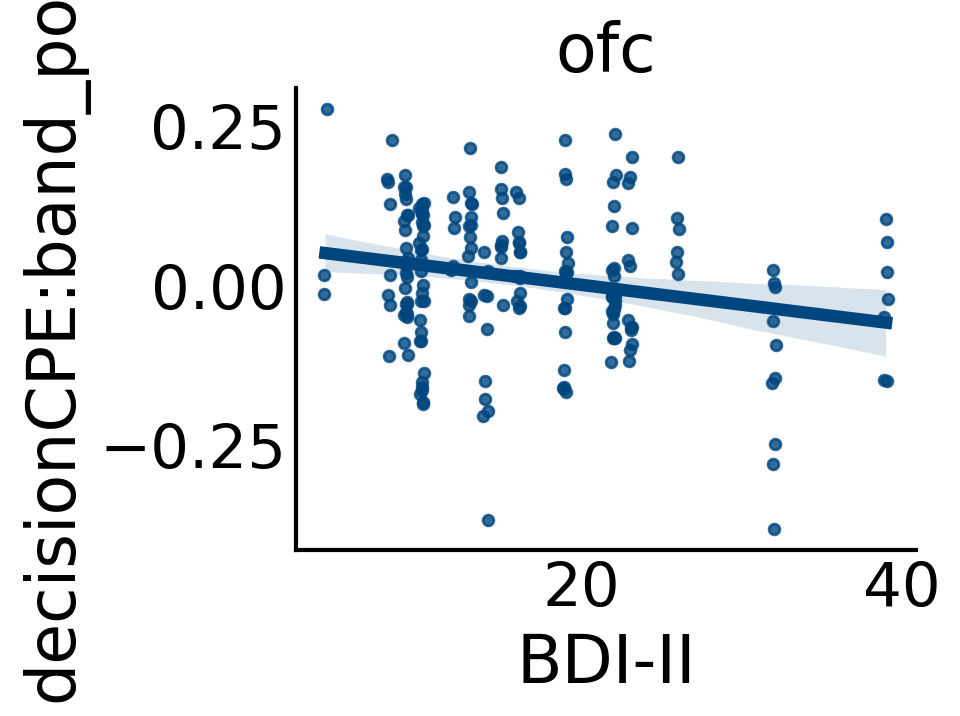

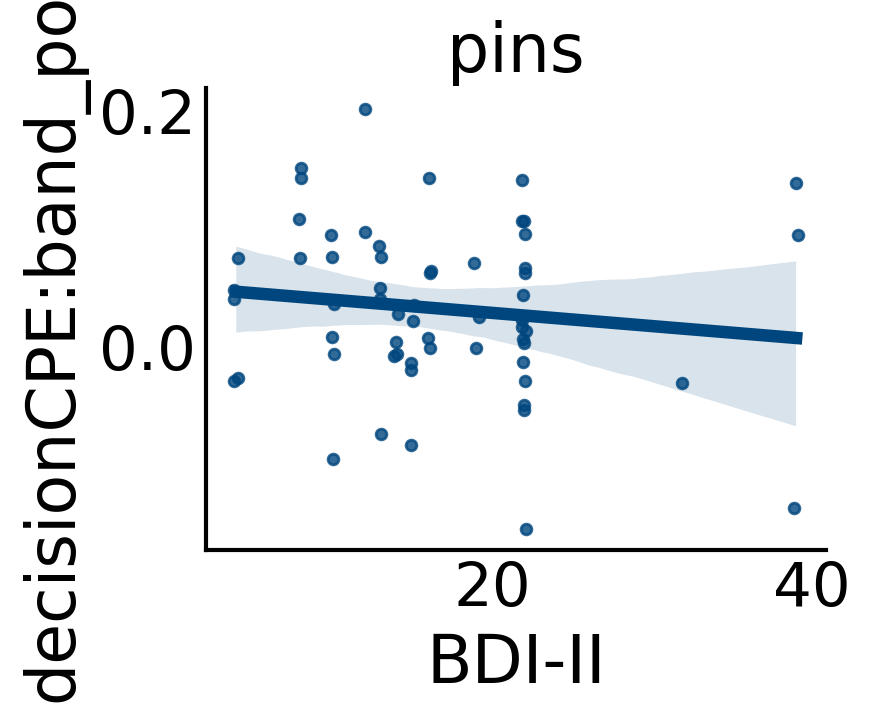

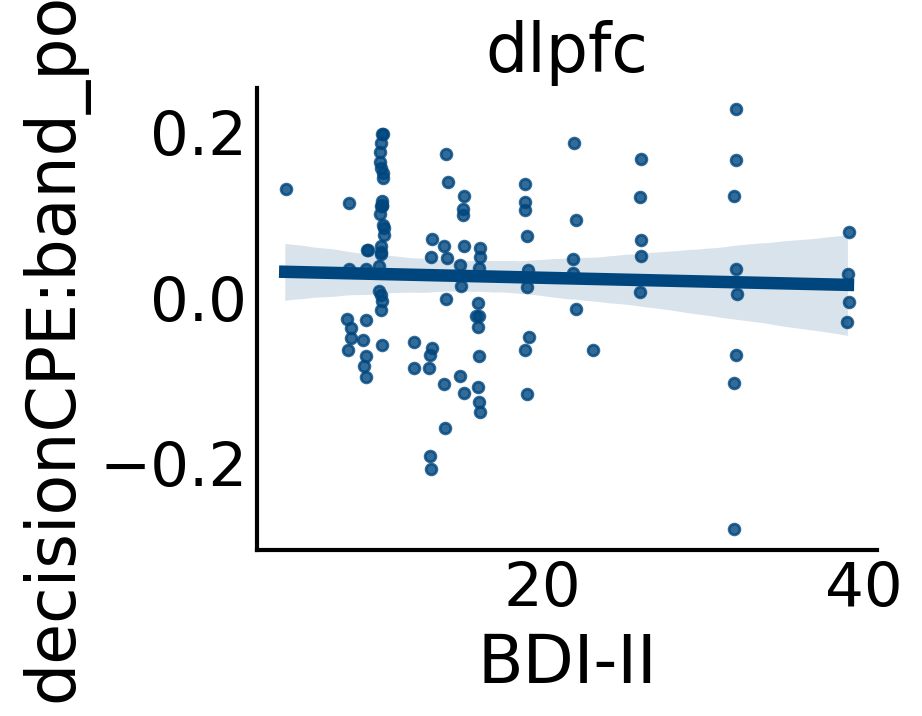

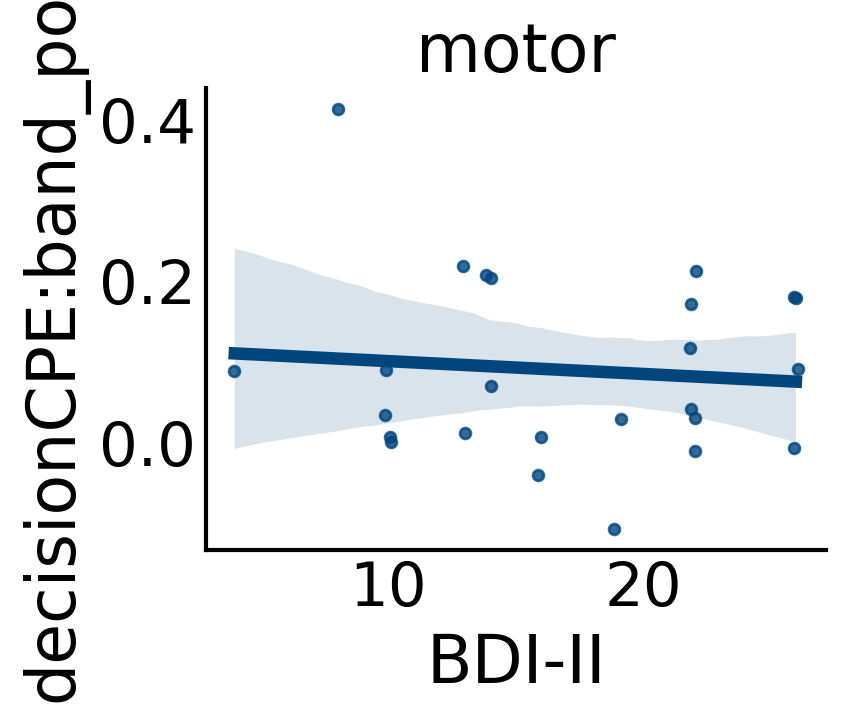

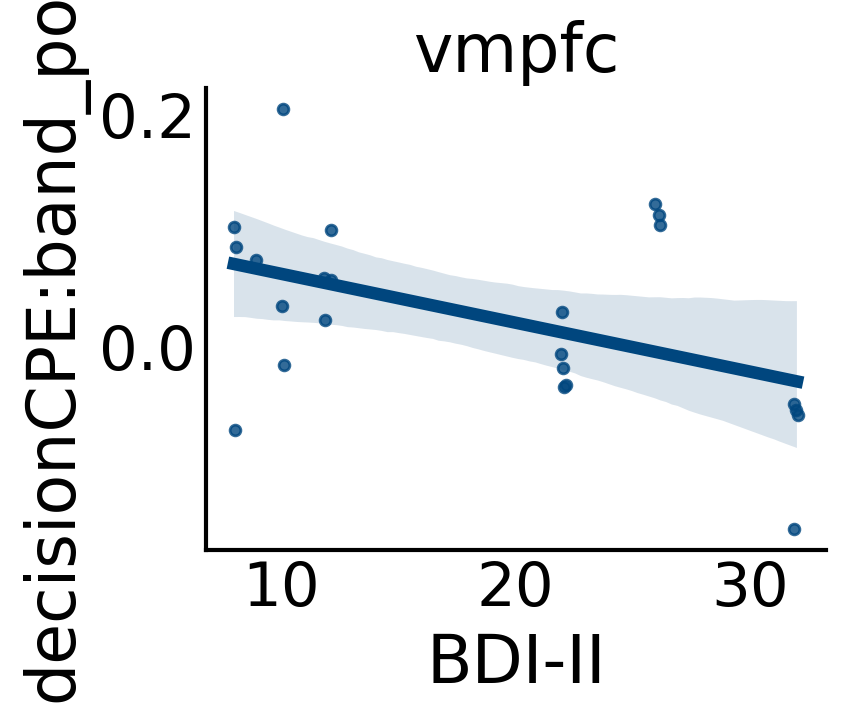

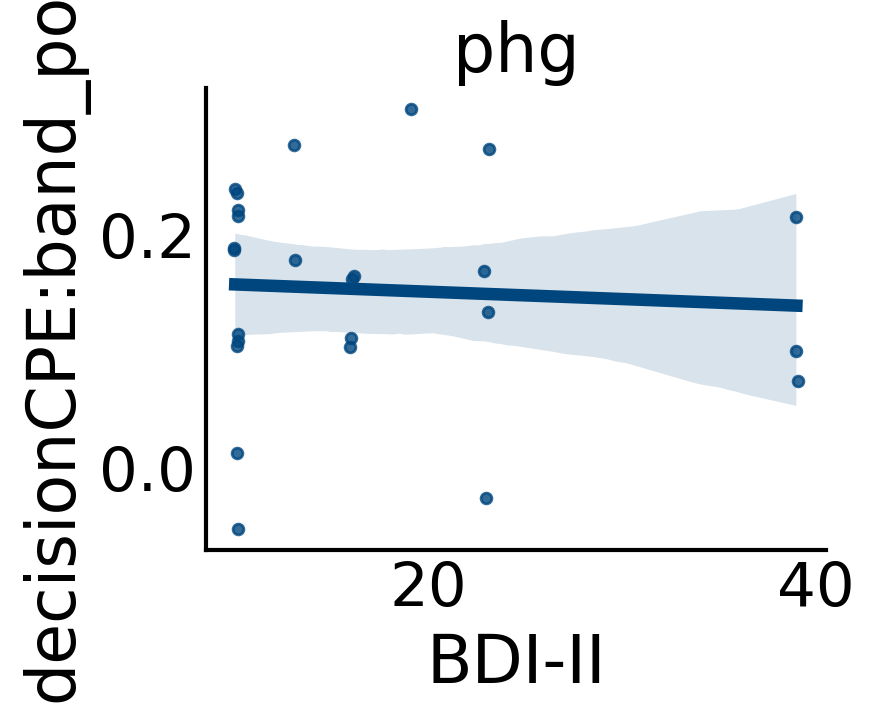

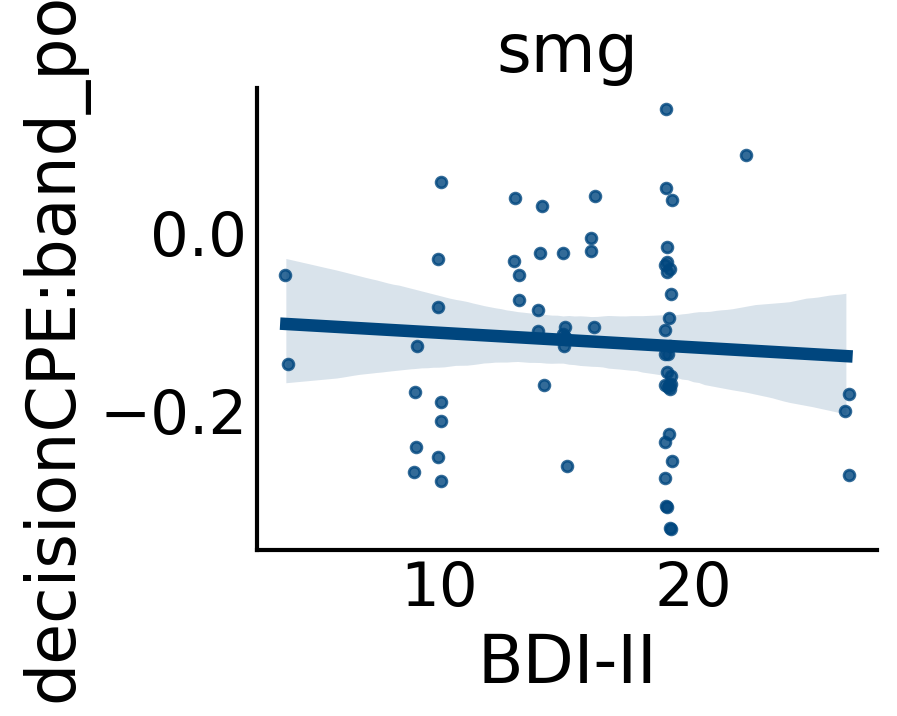

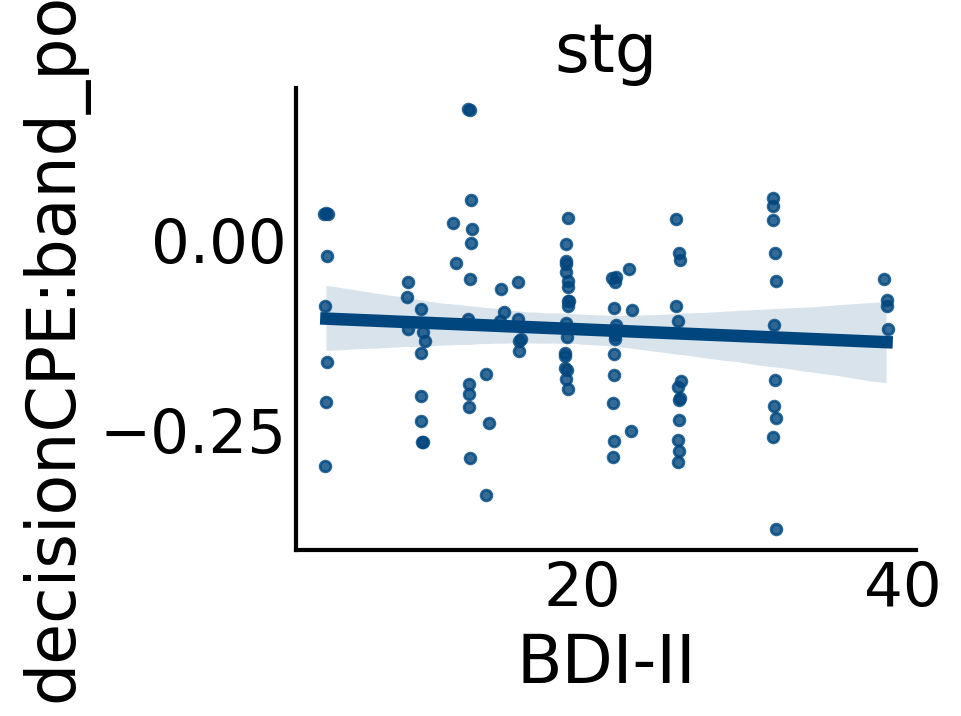

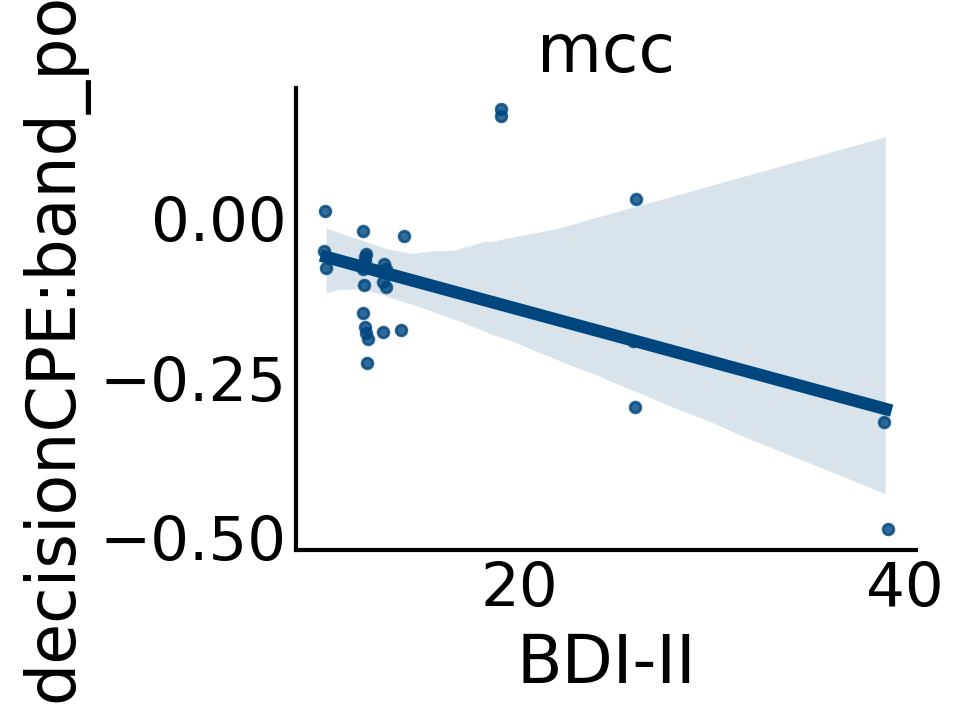

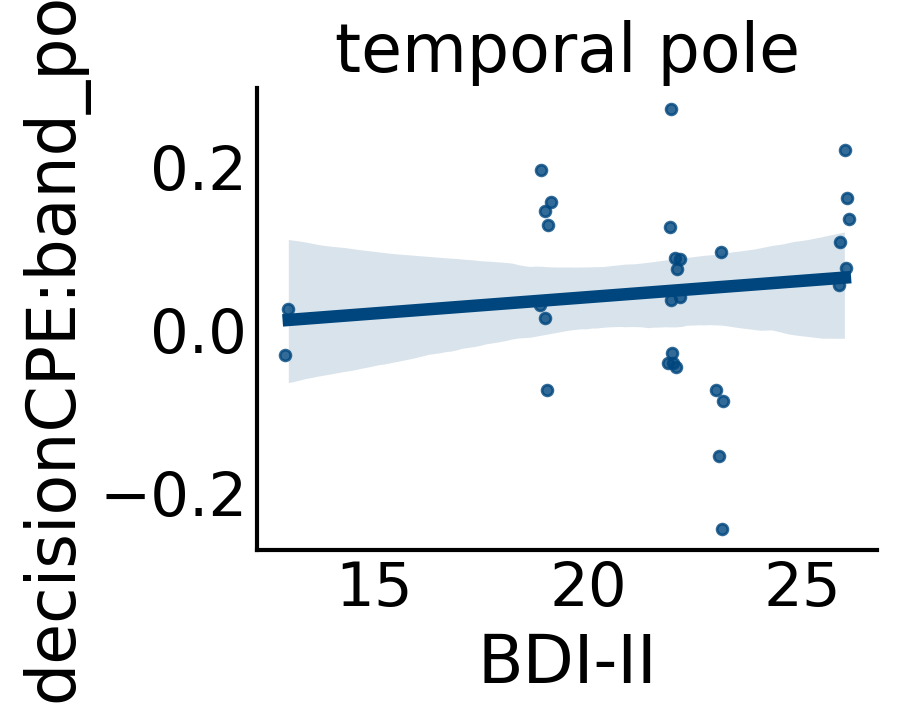

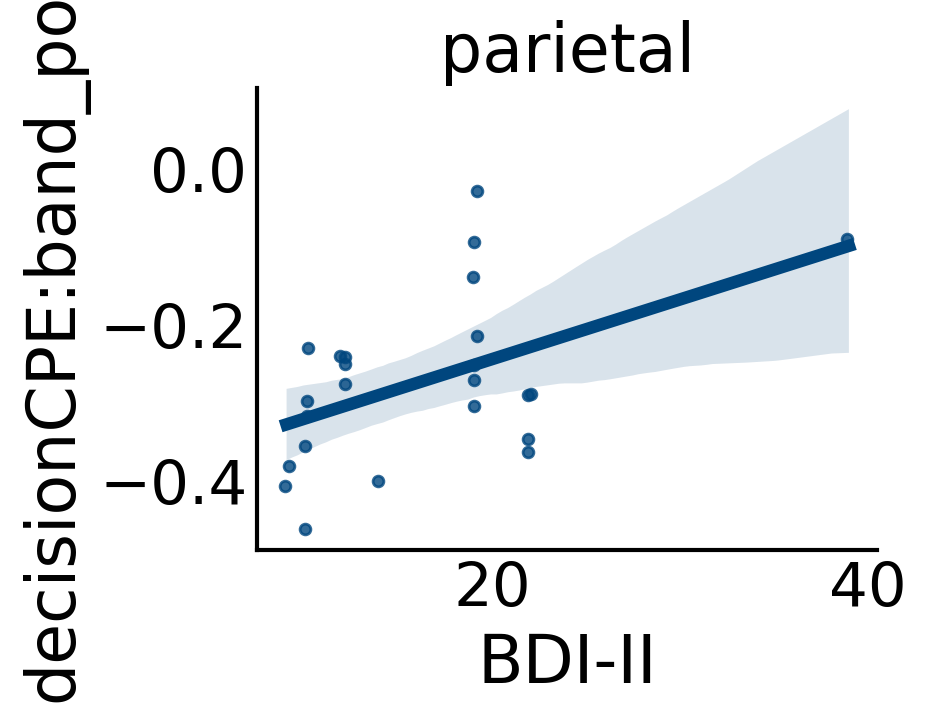

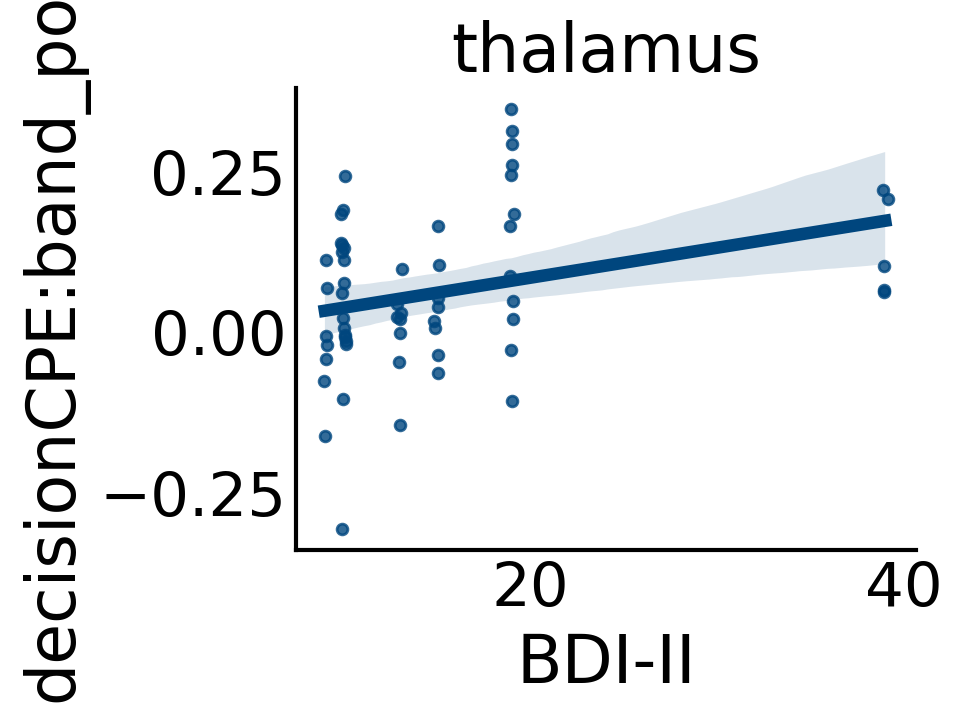

In [84]:

sns.set_context("poster",rc={'axes.linewidth': 1.5})

for roi in roi_fit_results.roi.unique().tolist():
    
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='decisionCPE:band_pow',scatter=True,ci=95,
                fit_reg=True,color = '#00467e',x_jitter = 0.15,scatter_kws={'s':15}) #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
#     plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
#     plt.ylabel(fr'${band}_{{{zpow}}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}')
    sns.despine()
#     plt.tight_layout()


    
#     sns.despine()
    
# #     plt.savefig(f'{fig_save_dir}/{roi}_{rho}_{rho_p}_roi_bdi_beta-cpe-slope.pdf', format='pdf', metadata=None,
# #         bbox_inches='tight', pad_inches=0.1,dpi=300,
# #         facecolor='auto', edgecolor='auto',
# #         backend=None)
    